# 📊 Comparison of YOLOv8 Model Configurations
---

# 🛠️ Setup
- setup environment and directories
- install and import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi
!nvcc --version

Mon Jan 20 01:50:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install ultralytics
!pip install supervision
!pip install ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.4/910.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
# import libraries
import ultralytics
from ultralytics import YOLO
from ultralytics.utils.benchmarks import benchmark

import os, json, shutil
from pathlib import Path
import gc

import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ffmpeg
import supervision as sv
import cv2

from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 📶 Model Comparison

The chart below highlights different YOLOv8 configurations tested in this project with the reasoning behind each approach.

| Model   | Configuration Details                                                                                           | Distinction                                                                                                 |
|---------|----------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------|
| Model 1 | Baseline: Standard YOLOv8 training with 50 epochs and batch size of 32.                                        | Used as a benchmark to evaluate the impact of additional optimization techniques.                          |
| Model 2 | Baseline with the first 10 layers frozen.                                                                      | Explored transfer learning by freezing earlier layers to focus training on task-specific data.             |
| Model 3 | Added 5% null background images to the dataset.                                                                | Evaluated the impact of background noise to improve robustness in complex scenes.                          |
| Model 4 | First 22 layers frozen using a custom callback function.                                                       | Tested deeper layer freezing to refine transfer learning and improve task-specific feature extraction.     |
| Model 5 | Model 4 with focal loss applied.                                                                               | Assessed whether focal loss improves detection for smaller and harder-to-detect objects.                   |
| Model 6 | Model 5 with SGD optimizer instead of the default.                                                             | Investigated how using a different optimizer affects convergence and final performance.                    |
| Model 7 | Model 5 with RMSProp optimizer instead of the default.                                                         | Tested alternative optimizer performance in handling diverse gradients in the training process.            |
| Model 8 | Model 5 without mosaic augmentation for the last 10 epochs.                                                    | Analyzed the impact of reducing augmentation at the end of training to fine-tune performance on real data. |

### Key Insights
1. **Baseline Performance:** Model 1 provided a foundational benchmark.
2. **Layer Freezing:** Model 4 showed marginal gains by freezing deeper layers but introduced sensitivity to certain features.
3. **Focal Loss:** Model 5 demonstrated improved precision for smaller objects.
4. **Optimizers:** RMSProp (Model 7) outperformed SGD (Model 6) in terms of stability during training.
5. **Augmentation:** Model 8 revealed that reducing mosaic augmentation near the end of training enhanced real-world applicability.

---


## Model 1 - Baseline Performance
- **Objective:** Establish baseline performance as a reference for comparison with optimized configurations.  

- **Base Model:** yolov8s.pt  
- **Dataset:** custom_yaml  
- **Training Parameters:**  
  - Epochs: 50  
  - Batch Size: 32  
  - Image Size: Default (640x640)  



### 1.1 Training

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/engr5315'
project_dir = os.path.join(base_dir, 'runs')
custom_yaml = os.path.join(base_dir, 'coco-custom.yaml')
custom_with_null_yaml = os.path.join(base_dir, 'coco-custom-with-null.yaml')
custom_focal_loss_yaml = os.path.join(base_dir, 'coco-focal-loss.yaml')

test_results = {}

In [ ]:
model = YOLO('yolov8s.pt')
results = model.train(
    data=custom_yaml,
    epochs=50,
    batch=32,
    project=project_dir)

100%|██████████| 21.5M/21.5M [00:00<00:00, 60.6MB/s]


Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/engr5315/coco-custom.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/engr5315/runs, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.2MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom/labels/train.cache... 10643 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10643/10643 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom/labels/val.cache... 1330 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1330/1330 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.65G      1.035      1.695      1.171        173        640: 100%|██████████| 333/333 [06:39<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]


                   all       1330       4672      0.715      0.577      0.637      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.55G      1.163       1.38      1.259         73        640: 100%|██████████| 333/333 [00:56<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]

                   all       1330       4672      0.654      0.487      0.548       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.45G        1.2      1.418      1.285        164        640: 100%|██████████| 333/333 [00:55<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


                   all       1330       4672      0.683       0.47       0.54       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       7.5G      1.227      1.455      1.303        100        640: 100%|██████████| 333/333 [00:55<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]

                   all       1330       4672      0.697      0.488      0.561      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.34G      1.196      1.374      1.283        126        640: 100%|██████████| 333/333 [00:55<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]

                   all       1330       4672      0.719      0.541      0.608      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.46G      1.173      1.323       1.27        110        640: 100%|██████████| 333/333 [00:55<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]

                   all       1330       4672      0.715      0.558      0.623      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       7.5G      1.148       1.27      1.253        123        640: 100%|██████████| 333/333 [00:55<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]

                   all       1330       4672       0.72      0.562       0.63      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.31G      1.129      1.235      1.238        163        640: 100%|██████████| 333/333 [00:55<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]

                   all       1330       4672      0.749      0.563      0.642      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.48G      1.108      1.192      1.227        115        640: 100%|██████████| 333/333 [00:55<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]

                   all       1330       4672      0.742      0.589      0.657       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.33G      1.099      1.163      1.219        144        640: 100%|██████████| 333/333 [00:55<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]

                   all       1330       4672       0.78      0.584      0.667      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.32G       1.08      1.133      1.209         95        640: 100%|██████████| 333/333 [00:55<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]

                   all       1330       4672      0.748      0.585      0.667      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.31G      1.069      1.108        1.2        120        640: 100%|██████████| 333/333 [00:55<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]

                   all       1330       4672      0.762       0.59      0.671      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.52G      1.059      1.084       1.19         85        640: 100%|██████████| 333/333 [00:55<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]

                   all       1330       4672      0.764      0.616       0.68      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       7.2G      1.041      1.055      1.182        140        640: 100%|██████████| 333/333 [00:55<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]

                   all       1330       4672      0.771      0.601      0.682       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.38G      1.033      1.038      1.177        137        640: 100%|██████████| 333/333 [00:55<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]

                   all       1330       4672      0.783      0.605      0.682      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.37G      1.032      1.024      1.172        141        640: 100%|██████████| 333/333 [00:55<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]


                   all       1330       4672      0.761      0.623      0.693      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.48G      1.017      1.007      1.164        134        640: 100%|██████████| 333/333 [00:55<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]

                   all       1330       4672      0.799      0.614      0.702      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.38G      1.016     0.9942      1.164        119        640: 100%|██████████| 333/333 [00:55<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]


                   all       1330       4672      0.775      0.636      0.706      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.24G      1.005     0.9744      1.155        130        640: 100%|██████████| 333/333 [00:55<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.50it/s]

                   all       1330       4672      0.796      0.625      0.707      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       7.4G     0.9933     0.9568      1.154        104        640: 100%|██████████| 333/333 [00:55<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]

                   all       1330       4672      0.804      0.633      0.711      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.31G     0.9847     0.9355      1.146        160        640: 100%|██████████| 333/333 [00:55<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]

                   all       1330       4672      0.788      0.629      0.714       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.35G     0.9762     0.9251      1.135        142        640: 100%|██████████| 333/333 [00:55<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.39it/s]

                   all       1330       4672      0.771      0.641      0.717      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.33G      0.965     0.9106      1.134        110        640: 100%|██████████| 333/333 [00:55<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]

                   all       1330       4672      0.779      0.647      0.718      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.47G     0.9671     0.8992      1.132        113        640: 100%|██████████| 333/333 [00:55<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]

                   all       1330       4672      0.812      0.622      0.715      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       7.5G     0.9604     0.8786      1.124        143        640: 100%|██████████| 333/333 [00:55<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]

                   all       1330       4672      0.801      0.639      0.727      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.32G     0.9459     0.8694      1.117        112        640: 100%|██████████| 333/333 [00:55<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]

                   all       1330       4672      0.782       0.65       0.72      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.28G      0.938     0.8528      1.115        125        640: 100%|██████████| 333/333 [00:55<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.46it/s]

                   all       1330       4672      0.786       0.65      0.726      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.26G     0.9385     0.8371      1.109         98        640: 100%|██████████| 333/333 [00:55<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]

                   all       1330       4672      0.805      0.655      0.734      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.54G     0.9242     0.8218      1.104        115        640: 100%|██████████| 333/333 [00:55<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.33it/s]

                   all       1330       4672      0.801      0.654      0.732      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       7.3G        inf     0.8177        1.1        118        640: 100%|██████████| 333/333 [00:55<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]

                   all       1330       4672      0.799       0.65      0.729      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.18G      0.913     0.8057      1.099         90        640: 100%|██████████| 333/333 [00:55<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]

                   all       1330       4672      0.805      0.649      0.729      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.31G     0.9066     0.7995      1.095        117        640: 100%|██████████| 333/333 [00:55<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]

                   all       1330       4672      0.798      0.658       0.73      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.31G     0.8958     0.7793      1.087         99        640: 100%|██████████| 333/333 [00:55<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]

                   all       1330       4672      0.815      0.655      0.737      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.42G     0.8954      0.768      1.085        151        640: 100%|██████████| 333/333 [00:54<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]

                   all       1330       4672        0.8      0.667      0.737      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.45G      0.887     0.7581      1.081        127        640: 100%|██████████| 333/333 [00:55<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]

                   all       1330       4672      0.816      0.664      0.739      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.33G     0.8768     0.7413      1.076        119        640: 100%|██████████| 333/333 [00:55<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]

                   all       1330       4672      0.808       0.66      0.737      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.25G      0.882     0.7387      1.077        106        640: 100%|██████████| 333/333 [00:55<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]

                   all       1330       4672        0.8      0.671      0.739      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.53G     0.8666     0.7191       1.07        144        640: 100%|██████████| 333/333 [00:55<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]

                   all       1330       4672      0.807      0.663       0.74      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.38G     0.8638       0.72      1.069         96        640: 100%|██████████| 333/333 [00:55<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]

                   all       1330       4672      0.819      0.655      0.739      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.35G     0.8555     0.7029      1.059        116        640: 100%|██████████| 333/333 [00:55<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.46it/s]

                   all       1330       4672      0.832      0.657      0.736      0.537


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.26G     0.8342     0.6316      1.032         63        640: 100%|██████████| 333/333 [00:56<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]

                   all       1330       4672      0.797      0.664      0.735      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.08G     0.8225     0.6015      1.021         54        640: 100%|██████████| 333/333 [00:53<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]

                   all       1330       4672      0.816      0.652      0.734      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.17G     0.8142     0.5914      1.017         98        640: 100%|██████████| 333/333 [00:53<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]

                   all       1330       4672      0.796      0.677      0.739      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.24G      0.808     0.5786      1.011         85        640: 100%|██████████| 333/333 [00:53<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]

                   all       1330       4672      0.797      0.672      0.741       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.31G     0.8012     0.5663      1.006         53        640: 100%|██████████| 333/333 [00:54<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]

                   all       1330       4672      0.809      0.661      0.738      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.27G     0.7922     0.5552      1.002         86        640: 100%|██████████| 333/333 [00:53<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]

                   all       1330       4672      0.818      0.662       0.74       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.18G     0.7859     0.5456     0.9995         67        640: 100%|██████████| 333/333 [00:53<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]

                   all       1330       4672      0.805      0.677      0.741      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.32G     0.7779     0.5363     0.9933         38        640: 100%|██████████| 333/333 [00:53<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]

                   all       1330       4672       0.83      0.662      0.741      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       7.2G      0.774     0.5303     0.9899         54        640: 100%|██████████| 333/333 [00:53<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]

                   all       1330       4672      0.817      0.666      0.741      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.18G      0.768     0.5248      0.988         69        640: 100%|██████████| 333/333 [00:53<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]

                   all       1330       4672      0.821      0.662       0.74      0.539



50 epochs completed in 0.962 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


                   all       1330       4672      0.818      0.661      0.741       0.54
                person        586       1254      0.846      0.626      0.723      0.483
               bicycle        134        242      0.779      0.521      0.637      0.428
                   car        480       1097      0.764      0.597      0.685      0.474
            motorcycle        144        263      0.858      0.722      0.814      0.581
                   bus        139        204      0.864       0.75      0.839      0.704
                 train        238        286      0.843      0.822      0.874      0.683
                 truck        273        433      0.669      0.513      0.614       0.44
         traffic light        160        428      0.816      0.507      0.586      0.338
          fire hydrant        140        147       0.93      0.844      0.907      0.661
             stop sign        169        197       0.84      0.787      0.848      0.702
         parking mete

In [ ]:
# results.results_dict
results.save_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/engr5315/runs/train')

In [ ]:
print(results.box.map)    # map50-95
print(results.box.map50)  # map50
print(results.box.map75)  # map75
print(results.box.maps)

0.5401546111638106
0.7405416575219103
0.5889353580767875
[    0.48344     0.42767     0.47382     0.58107     0.70445     0.68295     0.43968     0.33823     0.66126      0.7019     0.44722]


### 1.2 Validation

In [ ]:
runs_dir = results.save_dir
best_model_path = os.path.join(runs_dir, 'weights/best.pt')
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from best model
model = YOLO(best_model_path)
metrics = model.val(data=custom_yaml, split='test', project=project_dir, save_json=True)
test_results['run_01_best'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom/labels/test.cache... 1331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1331/1331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [00:52<00:00,  1.59it/s]


                   all       1331       4780      0.788      0.638      0.705      0.519
                person        558       1222      0.822      0.587      0.683       0.46
               bicycle        114        207      0.748      0.536      0.569      0.374
                   car        496       1202      0.732      0.611      0.669      0.448
            motorcycle        161        261      0.816      0.651      0.737      0.525
                   bus        131        214      0.887      0.738      0.825      0.664
                 train        214        297      0.863      0.782      0.876      0.662
                 truck        277        428      0.626      0.547      0.596      0.428
         traffic light        176        465      0.717      0.485      0.545      0.324
          fire hydrant        185        191      0.895      0.802      0.847      0.674
             stop sign        170        187      0.813      0.765      0.825      0.732
         parking mete

In [ ]:
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from last model
model = YOLO(last_model_path)
metrics = model.val(data=custom_yaml, split='test', project=project_dir, save_json=True)
test_results['run_01_last'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom/labels/test.cache... 1331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1331/1331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [00:17<00:00,  4.72it/s]


                   all       1331       4780      0.812      0.627      0.707      0.522
                person        558       1222       0.85      0.577      0.693      0.466
               bicycle        114        207      0.719      0.532      0.566      0.375
                   car        496       1202      0.778      0.588      0.675      0.453
            motorcycle        161        261      0.871      0.649       0.75       0.53
                   bus        131        214      0.892      0.735      0.827      0.671
                 train        214        297      0.885      0.778      0.872      0.665
                 truck        277        428      0.649      0.528      0.591      0.429
         traffic light        176        465      0.728      0.478      0.541      0.325
          fire hydrant        185        191        0.9      0.801      0.848      0.677
             stop sign        170        187      0.832      0.759      0.827      0.732
         parking mete

In [ ]:
pd.DataFrame(test_results)

run_01_best  run_01_last
metrics/precision(B)     0.788032     0.811603
metrics/recall(B)        0.638386     0.626985
metrics/mAP50(B)         0.705383     0.707358
metrics/mAP50-95(B)      0.519080     0.522249
fitness                  0.537710     0.540760

### 1.3 Results

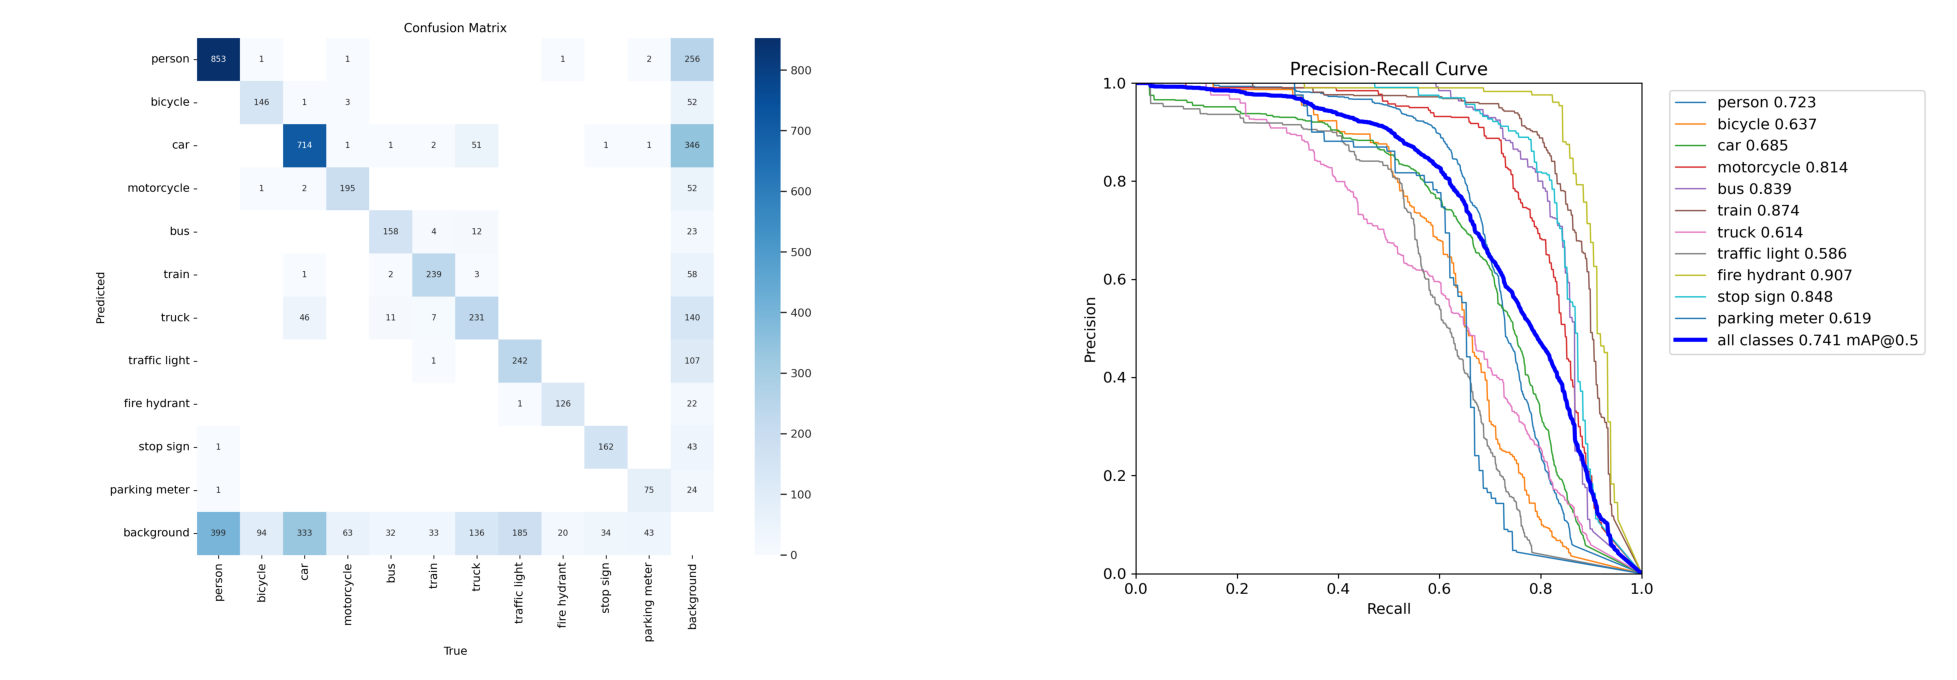

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,15))

img = mpimg.imread(os.path.join(runs_dir, 'confusion_matrix.png'))
ax[0].imshow(img)
ax[0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'PR_curve.png'))
ax[1].imshow(img)
ax[1].axis('off')
plt.show()

In [ ]:
# label verification
fig,ax = plt.subplots(3,3, figsize=(25,15))

# 1st row - train batch for label verification
img = mpimg.imread(os.path.join(runs_dir, 'train_batch0.jpg'))
ax[0,0].imshow(img)
ax[0,0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'train_batch1.jpg'))
ax[0,1].imshow(img)
ax[0,1].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'train_batch2.jpg'))
ax[0,2].imshow(img)
ax[0,2].axis('off')

# 2nd row - validation batch labels
img = mpimg.imread(os.path.join(runs_dir, 'val_batch0_labels.jpg'))
ax[1,0].imshow(img)
ax[1,0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'val_batch1_labels.jpg'))
ax[1,1].imshow(img)
ax[1,1].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'val_batch2_labels.jpg'))
ax[1,2].imshow(img)
ax[1,2].axis('off')

# 3rd row - validation batch predictions
img = mpimg.imread(os.path.join(runs_dir, 'val_batch0_pred.jpg'))
ax[2,0].imshow(img)
ax[2,0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'val_batch1_pred.jpg'))
ax[2,1].imshow(img)
ax[2,1].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'val_batch2_pred.jpg'))
ax[2,2].imshow(img)
ax[2,2].axis('off')

plt.show()


Output hidden; open in https://colab.research.google.com to view.

### 1.4 Image Inference

In [ ]:
test_src_dir = os.path.join(base_dir, 'datasets/test')
prediction_results = model.predict(test_src_dir, save=True, save_txt=True, verbose=False, project=project_dir)

Results saved to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/predict
3 labels saved to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/predict/labels


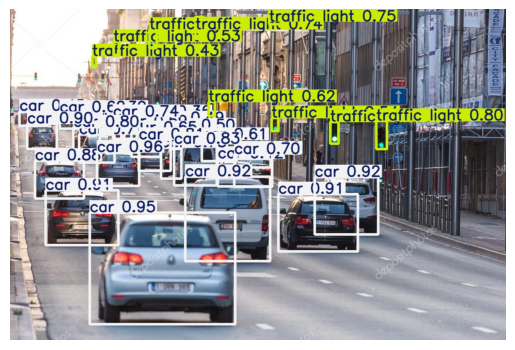

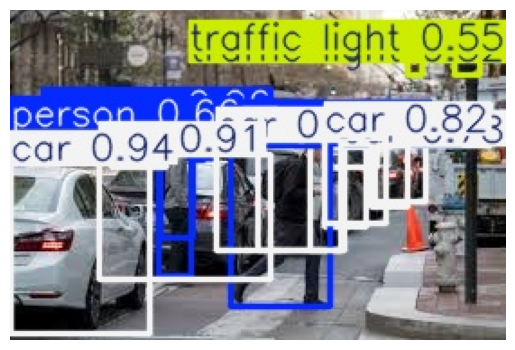

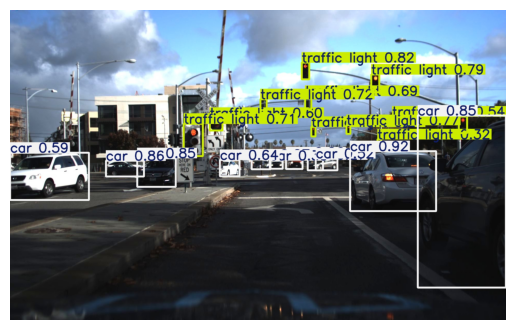

In [ ]:
# source_dir = '/content/runs/detect/predict'
predict_dir = prediction_results[0].save_dir

img_path = predict_dir + '/test01.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

img_path = predict_dir + '/test02.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

img_path = predict_dir + '/test03.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

---

## Model 2 - Transfer Learning with Frozen Layers
- **Objective:** Evaluate the impact of freezing earlier layers to focus training on task-specific features
- **Base Model:** yolov8s.pt
- **Dataset:** coco-custom.yaml
- **Training Parameters:**
 - Epochs: 50
 - Batch Size: 32
 - Freeze: 10
 - Image Size: Default (640x640)



### 2.1 Training

In [ ]:
model = YOLO('yolov8s.pt')
results = model.train(
    data=custom_yaml,
    epochs=50,
    batch=32,
    freeze=10,
    project=project_dir)

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/engr5315/coco-custom.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/engr5315/runs, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fal

train: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom/labels/train.cache... 10643 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10643/10643 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom/labels/val.cache... 1330 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1330/1330 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.62G       1.02      1.672      1.159        173        640: 100%|██████████| 333/333 [00:57<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]

                   all       1330       4672      0.822      0.646      0.744      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.65G      1.073      1.127       1.19         73        640: 100%|██████████| 333/333 [00:55<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]

                   all       1330       4672      0.764       0.67      0.735      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.69G      1.082      1.107      1.199        164        640: 100%|██████████| 333/333 [00:54<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.44it/s]

                   all       1330       4672      0.783      0.661      0.732      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.89G      1.091      1.095      1.202        100        640: 100%|██████████| 333/333 [00:55<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.34it/s]

                   all       1330       4672      0.803      0.647      0.733      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.83G      1.068      1.041      1.186        126        640: 100%|██████████| 333/333 [00:54<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]

                   all       1330       4672      0.801      0.659      0.738      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.68G      1.053      1.018       1.18        110        640: 100%|██████████| 333/333 [00:54<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]

                   all       1330       4672      0.817      0.664      0.746      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.77G      1.039     0.9922      1.173        123        640: 100%|██████████| 333/333 [00:55<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]

                   all       1330       4672      0.811      0.673      0.757      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.73G      1.024     0.9697      1.163        163        640: 100%|██████████| 333/333 [00:55<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.40it/s]

                   all       1330       4672      0.816      0.675      0.756       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.76G      1.016      0.948      1.156        115        640: 100%|██████████| 333/333 [00:54<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]

                   all       1330       4672      0.831      0.685      0.764      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.5G      1.006     0.9331       1.15        144        640: 100%|██████████| 333/333 [00:55<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]

                   all       1330       4672      0.823      0.673      0.757       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.55G     0.9921     0.9187      1.144         95        640: 100%|██████████| 333/333 [00:54<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]

                   all       1330       4672      0.814      0.684      0.767      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.73G     0.9867     0.9059      1.141        120        640: 100%|██████████| 333/333 [00:55<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.50it/s]

                   all       1330       4672      0.859      0.659      0.763      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.68G     0.9789     0.8985      1.132         85        640: 100%|██████████| 333/333 [00:54<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.40it/s]

                   all       1330       4672      0.831       0.68      0.767      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.58G      0.965     0.8826      1.126        140        640: 100%|██████████| 333/333 [00:54<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.50it/s]

                   all       1330       4672      0.843      0.674      0.769      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.56G     0.9589      0.872      1.124        137        640: 100%|██████████| 333/333 [00:54<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]

                   all       1330       4672      0.821      0.688      0.769      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.75G     0.9658     0.8706      1.123        141        640: 100%|██████████| 333/333 [00:54<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]


                   all       1330       4672      0.818      0.692      0.769      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.75G     0.9486     0.8559      1.117        134        640: 100%|██████████| 333/333 [00:54<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]

                   all       1330       4672      0.827      0.684      0.769      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.49G     0.9534     0.8532       1.12        119        640: 100%|██████████| 333/333 [00:55<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]

                   all       1330       4672      0.822      0.695      0.773      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.52G     0.9406     0.8418      1.112        130        640: 100%|██████████| 333/333 [00:54<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.38it/s]

                   all       1330       4672      0.827      0.699      0.773      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.57G     0.9384     0.8357      1.117        104        640: 100%|██████████| 333/333 [00:54<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]


                   all       1330       4672      0.838      0.688      0.774      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.54G     0.9304     0.8207      1.106        160        640: 100%|██████████| 333/333 [00:55<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.34it/s]

                   all       1330       4672       0.81      0.702      0.775      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       3.5G     0.9275      0.821      1.103        142        640: 100%|██████████| 333/333 [00:55<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]

                   all       1330       4672      0.839      0.681       0.77      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.75G     0.9192     0.8104      1.101        110        640: 100%|██████████| 333/333 [00:54<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]

                   all       1330       4672      0.833      0.684      0.773      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.59G     0.9209     0.8059        1.1        113        640: 100%|██████████| 333/333 [00:54<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]

                   all       1330       4672      0.826      0.685      0.772      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       3.7G     0.9151     0.7941      1.094        143        640: 100%|██████████| 333/333 [00:54<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]

                   all       1330       4672      0.838      0.694      0.777      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.5G     0.9062      0.786       1.09        112        640: 100%|██████████| 333/333 [00:54<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]

                   all       1330       4672      0.818      0.691      0.777      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.74G     0.8986     0.7779      1.088        125        640: 100%|██████████| 333/333 [00:55<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]

                   all       1330       4672      0.817      0.704      0.777      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.59G     0.9049     0.7744      1.086         98        640: 100%|██████████| 333/333 [00:54<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]

                   all       1330       4672      0.822        0.7      0.778      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.85G     0.8977     0.7689      1.085        115        640: 100%|██████████| 333/333 [00:55<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.39it/s]

                   all       1330       4672      0.815      0.704      0.777      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.65G     0.8876     0.7655      1.081        118        640: 100%|██████████| 333/333 [00:54<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]

                   all       1330       4672      0.836      0.691      0.779      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.61G     0.8882      0.761       1.08         90        640: 100%|██████████| 333/333 [00:54<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]

                   all       1330       4672      0.838      0.692      0.776      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.65G     0.8831     0.7536      1.077        117        640: 100%|██████████| 333/333 [00:54<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.44it/s]

                   all       1330       4672      0.839      0.701      0.779      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.54G     0.8749     0.7433      1.071         99        640: 100%|██████████| 333/333 [00:55<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]

                   all       1330       4672      0.837      0.695      0.776      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.77G      0.876     0.7384      1.071        151        640: 100%|██████████| 333/333 [00:55<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]

                   all       1330       4672      0.843      0.696       0.78      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.59G     0.8704     0.7336      1.069        127        640: 100%|██████████| 333/333 [00:54<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]

                   all       1330       4672      0.834      0.696      0.774      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.73G     0.8623     0.7283      1.064        119        640: 100%|██████████| 333/333 [00:54<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]

                   all       1330       4672      0.843      0.691      0.776      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.48G     0.8713     0.7264      1.069        106        640: 100%|██████████| 333/333 [00:55<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.50it/s]

                   all       1330       4672      0.831      0.701      0.776      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.74G     0.8611     0.7174      1.063        144        640: 100%|██████████| 333/333 [00:54<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]

                   all       1330       4672      0.849      0.691      0.778      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.8G     0.8563     0.7179      1.063         96        640: 100%|██████████| 333/333 [00:55<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.50it/s]

                   all       1330       4672       0.82      0.707      0.776      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.72G     0.8535     0.7089      1.058        116        640: 100%|██████████| 333/333 [00:54<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.46it/s]

                   all       1330       4672      0.838      0.695      0.776      0.576


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.67G     0.8874     0.7401      1.067         63        640: 100%|██████████| 333/333 [00:55<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.46it/s]

                   all       1330       4672      0.815      0.684       0.76      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.62G     0.8733     0.7041      1.051         54        640: 100%|██████████| 333/333 [00:53<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]

                   all       1330       4672       0.83      0.679      0.762      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.55G     0.8659     0.6997       1.05         98        640: 100%|██████████| 333/333 [00:52<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]

                   all       1330       4672      0.817      0.681      0.761      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.56G      0.858     0.6883      1.045         85        640: 100%|██████████| 333/333 [00:52<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.44it/s]

                   all       1330       4672      0.828      0.681      0.763      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.55G     0.8573     0.6794      1.043         53        640: 100%|██████████| 333/333 [00:52<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


                   all       1330       4672      0.818      0.683      0.765      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.45G     0.8459     0.6721      1.038         86        640: 100%|██████████| 333/333 [00:53<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]

                   all       1330       4672      0.818      0.685      0.763      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.61G     0.8431     0.6615      1.037         67        640: 100%|██████████| 333/333 [00:53<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]

                   all       1330       4672      0.807      0.693      0.765      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.52G     0.8445     0.6596      1.034         38        640: 100%|██████████| 333/333 [00:52<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]

                   all       1330       4672      0.806      0.693      0.763       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.52G      0.841     0.6549       1.03         54        640: 100%|██████████| 333/333 [00:52<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.39it/s]

                   all       1330       4672      0.808      0.693      0.764       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.56G     0.8348     0.6498      1.031         69        640: 100%|██████████| 333/333 [00:53<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]

                   all       1330       4672      0.812       0.69      0.766      0.561



50 epochs completed in 0.859 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train2/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train2/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train2/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.90it/s]


                   all       1330       4672       0.84      0.694      0.776      0.576
                person        586       1254      0.851      0.667      0.764      0.535
               bicycle        134        242      0.738      0.521      0.651       0.44
                   car        480       1097      0.784      0.621      0.711      0.498
            motorcycle        144        263      0.925      0.747      0.844      0.603
                   bus        139        204      0.902      0.784      0.874      0.748
                 train        238        286      0.894      0.881      0.921      0.722
                 truck        273        433      0.771      0.598      0.698      0.524
         traffic light        160        428      0.818       0.54      0.626      0.374
          fire hydrant        140        147      0.914      0.884      0.916      0.689
             stop sign        169        197      0.912       0.79       0.89      0.744
         parking mete

### 2.2 Validation

In [ ]:
runs_dir = results.save_dir
best_model_path = os.path.join(runs_dir, 'weights/best.pt')
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from best model
model = YOLO(best_model_path)
metrics = model.val(data=custom_yaml, split='test', project=project_dir, save_json=True)
test_results['run_02_best'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom/labels/test.cache... 1331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1331/1331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [00:17<00:00,  4.69it/s]


                   all       1331       4780      0.817      0.678      0.759      0.568
                person        558       1222      0.849      0.634      0.735      0.503
               bicycle        114        207      0.785       0.58      0.678      0.446
                   car        496       1202      0.759      0.631      0.709       0.48
            motorcycle        161        261      0.876      0.686      0.784      0.582
                   bus        131        214      0.881      0.798      0.886      0.738
                 train        214        297      0.911      0.823      0.906      0.703
                 truck        277        428      0.691      0.626      0.668      0.507
         traffic light        176        465       0.78      0.505      0.596      0.351
          fire hydrant        185        191      0.919      0.791      0.878      0.715
             stop sign        170        187      0.809      0.795       0.86      0.748
         parking mete

In [ ]:
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from last model
model = YOLO(last_model_path)
metrics = model.val(data=custom_yaml, split='test', project=project_dir, save_json=True)
test_results['run_02_last'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom/labels/test.cache... 1331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1331/1331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [00:10<00:00,  7.73it/s]


                   all       1331       4780      0.815      0.667      0.747      0.559
                person        558       1222      0.869      0.632      0.731        0.5
               bicycle        114        207      0.727      0.575      0.633      0.423
                   car        496       1202      0.781      0.607      0.699      0.467
            motorcycle        161        261      0.907      0.678      0.788       0.58
                   bus        131        214       0.88      0.789      0.882      0.729
                 train        214        297      0.899      0.811      0.894      0.696
                 truck        277        428      0.678      0.572      0.652       0.49
         traffic light        176        465      0.792      0.503      0.583      0.342
          fire hydrant        185        191       0.89      0.775      0.855      0.705
             stop sign        170        187      0.824      0.807      0.854      0.747
         parking mete

### 2.3 Results

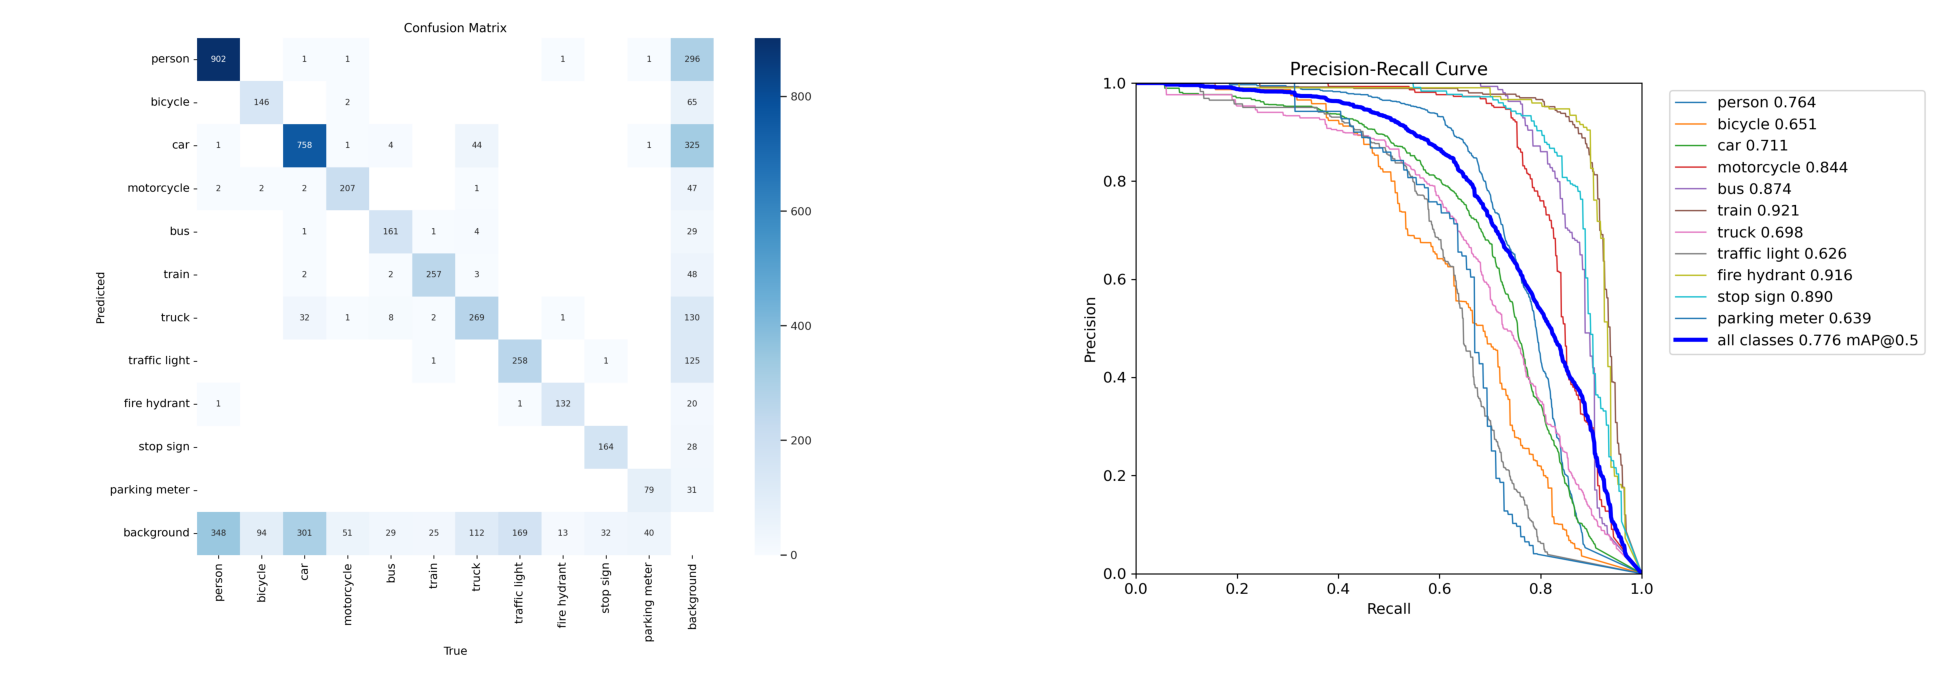

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,15))

img = mpimg.imread(os.path.join(runs_dir, 'confusion_matrix.png'))
ax[0].imshow(img)
ax[0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'PR_curve.png'))
ax[1].imshow(img)
ax[1].axis('off')
plt.show()

---

## Model 3 - Null Background Augmentation
- **Objective:** Test the inclusion of null background images to improve robustness in detecting objects in diverse environments
- **Base Model:** yolov8s.pt
- **Dasaset:** coco-custom-with-null.yaml (5% null background images added)
- **Training Parameters**
 - Epochs: 50
 - Batch Size: 32
 - Freeze: None (revert freezing)
 - Image Size: Default (640x640)



### 3.1 Training

In [ ]:
# Background images. Background images are images with no objects that are added to a dataset to reduce False Positives (FP).
# We recommend about 0-10% background images to help reduce FPs (COCO has 1000 background images for reference, 1% of the total).
# No labels are required for background images

model = YOLO('yolov8s.pt')
results = model.train(
    data=custom_with_null_yaml,
    epochs=50,
    batch=32,
    project=project_dir)

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/engr5315/coco-custom-with-null.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/engr5315/runs, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

train: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/train.cache... 10643 images, 530 backgrounds, 0 corrupt: 100%|██████████| 11173/11173 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/val.cache... 1330 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1397/1397 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       7.5G      1.036      1.716      1.172         55        640: 100%|██████████| 350/350 [02:39<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.29it/s]

                   all       1397       4672      0.685      0.551      0.604      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.46G      1.163      1.389      1.255         35        640: 100%|██████████| 350/350 [00:59<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.676      0.524      0.586      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       7.4G      1.219      1.454      1.293         16        640: 100%|██████████| 350/350 [00:59<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]

                   all       1397       4672      0.642      0.504      0.549      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.26G      1.237      1.461      1.312         29        640: 100%|██████████| 350/350 [00:59<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.692      0.495      0.557      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.25G      1.194      1.392      1.287         37        640: 100%|██████████| 350/350 [00:58<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.715      0.532      0.601      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.47G      1.169       1.34      1.268         31        640: 100%|██████████| 350/350 [00:59<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]

                   all       1397       4672      0.714      0.532      0.607      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.54G       1.15      1.277      1.255         14        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.738       0.56      0.626      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.38G      1.125      1.228      1.237         47        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.731      0.581      0.653       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.32G      1.112      1.198      1.227         26        640: 100%|██████████| 350/350 [00:59<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.725       0.59      0.654      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.24G      1.092      1.166      1.217         35        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.742      0.593      0.667      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       7.3G      1.089      1.138      1.211         35        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]

                   all       1397       4672      0.773      0.584      0.668      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.33G      1.076      1.121      1.204         22        640: 100%|██████████| 350/350 [00:59<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.791      0.574      0.668      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.55G      1.062       1.09      1.194         32        640: 100%|██████████| 350/350 [00:59<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.748      0.608      0.674      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.52G      1.049       1.07      1.187         16        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.763      0.591      0.669      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.28G      1.039      1.051      1.182         32        640: 100%|██████████| 350/350 [00:59<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.765      0.629      0.696      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.26G      1.021      1.023       1.17         53        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.32it/s]

                   all       1397       4672       0.76      0.631      0.695      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.59G      1.018      1.002      1.165         44        640: 100%|██████████| 350/350 [01:00<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.58it/s]

                   all       1397       4672      0.778      0.624      0.697      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       7.4G      1.016          1      1.166         28        640: 100%|██████████| 350/350 [00:59<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672       0.75      0.633      0.693      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.42G      1.003     0.9805       1.16         22        640: 100%|██████████| 350/350 [00:59<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]

                   all       1397       4672      0.783      0.625      0.695      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.34G     0.9901     0.9585      1.148         24        640: 100%|██████████| 350/350 [00:59<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.60it/s]

                   all       1397       4672      0.769       0.64      0.709       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.26G     0.9854     0.9484      1.144         28        640: 100%|██████████| 350/350 [00:59<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672        0.8      0.625      0.707      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.33G     0.9761     0.9267      1.138         31        640: 100%|██████████| 350/350 [00:59<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.789      0.625      0.708      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.48G     0.9712      0.924      1.137         33        640: 100%|██████████| 350/350 [00:59<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]

                   all       1397       4672       0.79      0.642       0.72      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       7.5G      0.966        0.9      1.131         45        640: 100%|██████████| 350/350 [00:59<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.784      0.655      0.719      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.36G     0.9532     0.8811      1.124         36        640: 100%|██████████| 350/350 [00:58<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]

                   all       1397       4672      0.784      0.642      0.718      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       7.6G     0.9535     0.8733      1.119         27        640: 100%|██████████| 350/350 [00:59<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]

                   all       1397       4672      0.786      0.658      0.726      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.23G     0.9393     0.8568      1.114         24        640: 100%|██████████| 350/350 [00:59<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672        0.8      0.656      0.725      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.59G     0.9307     0.8412      1.108         48        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]

                   all       1397       4672      0.796      0.645      0.723      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.48G     0.9268      0.831      1.106         35        640: 100%|██████████| 350/350 [01:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]

                   all       1397       4672      0.786      0.668      0.728      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.26G     0.9173     0.8226      1.105         28        640: 100%|██████████| 350/350 [01:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.806       0.65      0.728      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       7.3G      0.916     0.8084      1.098         32        640: 100%|██████████| 350/350 [01:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.824      0.637      0.729      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.29G     0.9056     0.7955      1.093         12        640: 100%|██████████| 350/350 [00:59<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.808      0.657      0.734      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.35G     0.9026     0.7883      1.091         40        640: 100%|██████████| 350/350 [00:59<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]

                   all       1397       4672      0.778      0.664      0.729      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.34G     0.8963     0.7727      1.084         37        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.63it/s]

                   all       1397       4672      0.805      0.655      0.731       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.32G      0.888     0.7591      1.083         70        640: 100%|██████████| 350/350 [00:59<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

                   all       1397       4672      0.778      0.674      0.735      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.35G     0.8801     0.7491      1.077         33        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]

                   all       1397       4672      0.802      0.664      0.738      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.41G     0.8797     0.7435      1.077         30        640: 100%|██████████| 350/350 [00:59<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.60it/s]

                   all       1397       4672      0.792      0.669      0.736      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.44G     0.8742     0.7333      1.069         41        640: 100%|██████████| 350/350 [00:59<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

                   all       1397       4672      0.792      0.675      0.735      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       7.4G     0.8613     0.7175      1.065         28        640: 100%|██████████| 350/350 [00:58<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]

                   all       1397       4672      0.814      0.654      0.734      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.61G     0.8632     0.7115      1.065         22        640: 100%|██████████| 350/350 [00:59<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.66it/s]

                   all       1397       4672      0.792       0.67      0.736      0.537


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.16G     0.8415     0.6372      1.033         13        640: 100%|██████████| 350/350 [01:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.794      0.663      0.728      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.33G     0.8253     0.6053      1.023          8        640: 100%|██████████| 350/350 [00:57<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.66it/s]

                   all       1397       4672      0.826       0.64      0.727       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.25G     0.8157     0.5919      1.017         13        640: 100%|██████████| 350/350 [00:57<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.814      0.654      0.731      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.21G     0.8057     0.5798      1.012          8        640: 100%|██████████| 350/350 [00:56<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

                   all       1397       4672      0.812      0.653      0.728      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.24G      0.795     0.5668      1.005         12        640: 100%|██████████| 350/350 [00:57<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]

                   all       1397       4672      0.814      0.658      0.732      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.14G     0.7902     0.5541      1.002         15        640: 100%|██████████| 350/350 [00:57<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.814      0.652      0.729      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.16G     0.7835     0.5474     0.9972         15        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]

                   all       1397       4672      0.804      0.662      0.729      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.33G     0.7764     0.5379     0.9963         10        640: 100%|██████████| 350/350 [00:57<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.797      0.664      0.728      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       7.2G     0.7737     0.5306     0.9927         16        640: 100%|██████████| 350/350 [00:57<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]

                   all       1397       4672      0.803      0.666      0.728      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.31G     0.7663      0.524     0.9871         12        640: 100%|██████████| 350/350 [00:57<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.823      0.652      0.729      0.536



50 epochs completed in 0.961 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train3/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train3/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train3/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.94it/s]


                   all       1397       4672      0.791       0.67      0.736      0.537
                person        586       1254      0.837       0.63      0.724      0.485
               bicycle        134        242      0.735      0.521      0.626      0.413
                   car        480       1097      0.761      0.609      0.687      0.471
            motorcycle        144        263      0.828      0.745      0.801      0.555
                   bus        139        204      0.805       0.75      0.824      0.694
                 train        238        286      0.821      0.846      0.859      0.671
                 truck        273        433      0.696      0.582      0.643      0.458
         traffic light        160        428      0.739      0.522      0.593      0.338
          fire hydrant        140        147      0.912      0.857      0.895      0.679
             stop sign        169        197      0.832      0.772      0.843      0.705
         parking mete

### 3.2 Validation

In [ ]:
runs_dir = results.save_dir
best_model_path = os.path.join(runs_dir, 'weights/best.pt')
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from best model
model = YOLO(best_model_path)
metrics = model.val(data=custom_with_null_yaml, split='test', project=project_dir, save_json=True)
test_results['run_03_best'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [01:00<00:00,  1.46it/s]


                   all       1398       4780        0.8      0.634      0.707      0.522
                person        558       1222      0.842      0.577      0.685      0.449
               bicycle        114        207       0.72      0.527      0.586      0.388
                   car        496       1202      0.766      0.592      0.669      0.452
            motorcycle        161        261      0.862      0.667      0.729       0.51
                   bus        131        214      0.843      0.743      0.833      0.697
                 train        214        297      0.844      0.798      0.856      0.648
                 truck        277        428      0.644      0.548      0.588      0.436
         traffic light        176        465       0.75       0.48       0.57      0.334
          fire hydrant        185        191      0.904      0.796      0.848      0.674
             stop sign        170        187      0.836      0.749      0.825      0.721
         parking mete

In [ ]:
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from last model
model = YOLO(last_model_path)
metrics = model.val(data=custom_with_null_yaml, split='test', project=project_dir, save_json=True)
test_results['run_03_last'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:11<00:00,  7.81it/s]


                   all       1398       4780      0.776      0.652      0.706      0.522
                person        558       1222      0.812        0.6      0.685      0.451
               bicycle        114        207      0.683      0.589       0.59      0.396
                   car        496       1202      0.739       0.63       0.67       0.45
            motorcycle        161        261       0.84      0.662      0.747      0.528
                   bus        131        214      0.847      0.749      0.823      0.691
                 train        214        297      0.828      0.798      0.855      0.653
                 truck        277        428      0.617      0.556      0.573       0.43
         traffic light        176        465      0.696      0.517      0.561      0.333
          fire hydrant        185        191      0.889      0.791      0.855      0.677
             stop sign        170        187      0.792      0.733      0.815      0.715
         parking mete

In [ ]:
pd.DataFrame(test_results)

run_01_best  run_01_last  run_02_best  run_02_last  \
metrics/precision(B)     0.788032     0.811603     0.816686     0.814901   
metrics/recall(B)        0.638386     0.626985     0.678384     0.666831   
metrics/mAP50(B)         0.705383     0.707358     0.759135     0.746511   
metrics/mAP50-95(B)      0.519080     0.522249     0.568289     0.559047   
fitness                  0.537710     0.540760     0.587374     0.577794   

                      run_03_best  run_03_last  
metrics/precision(B)     0.800040     0.776094  
metrics/recall(B)        0.633503     0.652223  
metrics/mAP50(B)         0.707405     0.705881  
metrics/mAP50-95(B)      0.522197     0.522270  
fitness                  0.540718     0.540631

### 3.3 Results

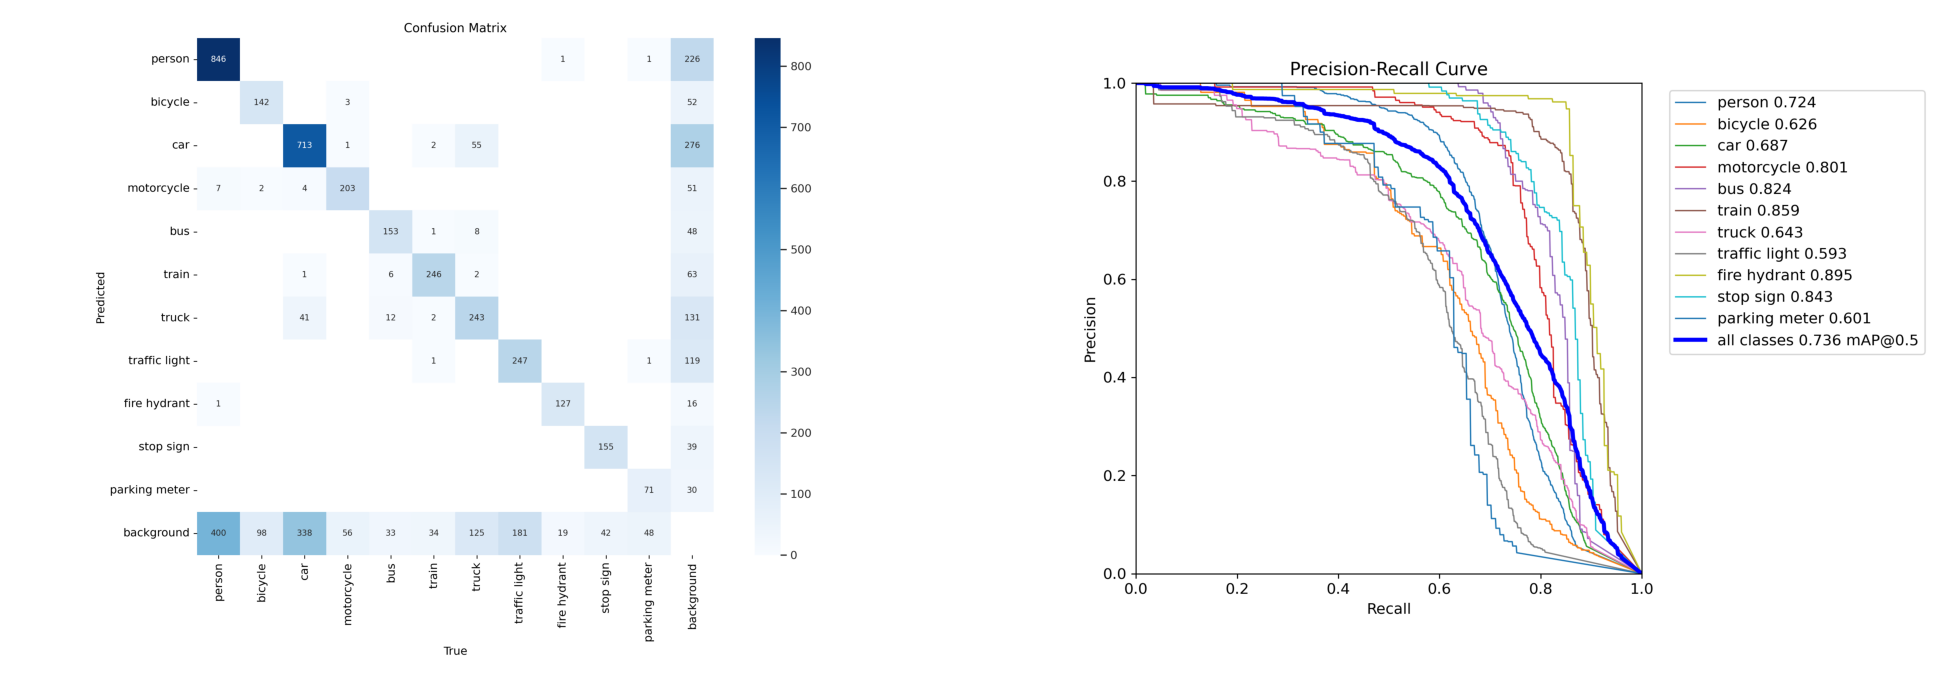

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,15))

img = mpimg.imread(os.path.join(runs_dir, 'confusion_matrix.png'))
ax[0].imshow(img)
ax[0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'PR_curve.png'))
ax[1].imshow(img)
ax[1].axis('off')
plt.show()

---

## Model 4 - Deep Layer Freezing
- **Objective:** Investigate the effect of freezing deeper layers on task-specific feature refinement.
 - Unreeze last layer only
 - Keep other previous settings

- **Base Model:** yolov8s.pt
- **Dataset:** custom_focal_loss.yaml
- **Training Parameters**
 - Epochs: 50
 - Batch Size: 32
 - Freeze: 22
 - Image Size: Default (640x640)



### 4.1 Training

In [ ]:
# custom function to freeze layers
def freeze_layer(trainer):
    model = trainer.model
    num_freeze = 22
    print(f"Freezing {num_freeze} layers")
    freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze
    for k, v in model.named_parameters():
      v.requires_grad = True  # train all layers
      if any(x in k for x in freeze):
        v.requires_grad = False
        print(f'freezing {k}, {v.requires_grad}')
      else:
        print(f'not freezing {k}, {v.requires_grad}')

    print(f"{num_freeze} layers are freezed.")

model = YOLO('yolov8s.pt')
model.add_callback('on_train_start', freeze_layer)
results = model.train(
    data=custom_with_null_yaml,
    epochs=50,
    batch=32,
    freeze=22,
    project=project_dir)

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/engr5315/coco-custom-with-null.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/engr5315/runs, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_

train: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/train.cache... 10643 images, 530 backgrounds, 0 corrupt: 100%|██████████| 11173/11173 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/val.cache... 1330 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1397/1397 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Freezing 22 layers
freezing model.0.conv.weight, False
freezing model.0.bn.weight, False
freezing model.0.bn.bias, False
freezing model.1.conv.weight, False
freezing model.1.bn.weight, False
freezing model.1.bn.bias, False
freezing model.2.cv1.conv.weight, False
freezing model.2.cv1.bn.weight, False
freezing model.2.cv1.bn.bias, False
freezing model.2.cv2.conv.weight, False
freezing model.2.cv2.bn.weight, False
freezing model.2.cv2.bn.bias, False
freezing model.2.m.0.cv1.conv.weight, False
freezing model.2.m.0.cv1.bn.weight, False
freezing model.2.m.0.cv1.bn.bias, False
freezing model.2.m.0.cv2.conv.weight, False
free

       1/50       4.2G      1.016      1.718      1.163         55        640: 100%|██████████| 350/350 [01:01<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.845      0.672      0.768      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.03G      1.009      1.063      1.149         35        640: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.833      0.685      0.769      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.2G      1.018      1.047       1.15         16        640: 100%|██████████| 350/350 [00:58<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all       1397       4672      0.833      0.689      0.775      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.94G      1.012      1.022      1.152         29        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.847      0.688      0.777      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.07G     0.9964      1.002      1.142         37        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]

                   all       1397       4672      0.852      0.688       0.78      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.3G     0.9957     0.9853       1.14         31        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]

                   all       1397       4672      0.857      0.689      0.783      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.2G     0.9986     0.9809      1.143         14        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.856      0.688      0.781      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.16G     0.9898     0.9636      1.135         47        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.864      0.684      0.778      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.12G      0.987     0.9602      1.135         26        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.852       0.69      0.782      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.16G     0.9815     0.9573      1.134         35        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.846      0.703      0.787        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.1G     0.9838     0.9445      1.132         35        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.32it/s]

                   all       1397       4672       0.85      0.701      0.788      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.06G     0.9861     0.9528      1.134         22        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]

                   all       1397       4672      0.864      0.691      0.787      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.29G     0.9792     0.9441      1.129         32        640: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.29it/s]

                   all       1397       4672      0.837      0.702      0.784      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.49G      0.976     0.9424      1.129         16        640: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672       0.85      0.695      0.786      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.99G     0.9694     0.9374      1.129         32        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.858      0.699      0.788      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.05G     0.9695     0.9367      1.129         53        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672       0.84       0.71       0.79      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.39G     0.9711     0.9276      1.127         44        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]

                   all       1397       4672      0.859      0.698      0.789      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.22G     0.9732     0.9338      1.129         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.862      0.697       0.79      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.97G     0.9688     0.9192      1.128         22        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]

                   all       1397       4672      0.861      0.695      0.788      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.07G     0.9648     0.9242      1.125         24        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.861        0.7      0.787      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.96G     0.9629      0.923      1.123         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672       0.86      0.698      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.05G     0.9626     0.9152      1.123         31        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]

                   all       1397       4672      0.831      0.708      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.25G     0.9622     0.9231      1.123         33        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.863      0.697      0.791      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.3G     0.9602     0.9109      1.124         45        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

                   all       1397       4672      0.872      0.699      0.792      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.99G      0.958     0.9101      1.121         36        640: 100%|██████████| 350/350 [00:58<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all       1397       4672      0.867        0.7      0.792      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.36G     0.9611     0.9063       1.12         27        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.865      0.692       0.79      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.07G     0.9552     0.9045      1.121         24        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.865      0.699      0.791      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.28G     0.9561     0.8971      1.119         48        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.31it/s]

                   all       1397       4672      0.854      0.707      0.791      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.26G     0.9547     0.9015       1.12         35        640: 100%|██████████| 350/350 [00:59<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.856      0.708      0.794       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.03G     0.9543     0.8979      1.121         28        640: 100%|██████████| 350/350 [00:59<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.861      0.704      0.791       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.08G     0.9506     0.8918      1.119         32        640: 100%|██████████| 350/350 [00:58<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

                   all       1397       4672      0.859      0.698      0.792      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.17G     0.9519     0.8913      1.118         12        640: 100%|██████████| 350/350 [00:59<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.857      0.699      0.792       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.05G     0.9552     0.8979      1.119         40        640: 100%|██████████| 350/350 [00:58<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672       0.84      0.709      0.791      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.04G     0.9538     0.8962      1.116         37        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]

                   all       1397       4672      0.855      0.707      0.793      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.02G     0.9462     0.8825      1.115         70        640: 100%|██████████| 350/350 [00:58<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.852      0.709      0.793      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.04G     0.9469     0.8829      1.116         33        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.55it/s]

                   all       1397       4672      0.861      0.702      0.794      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.11G      0.953     0.8875       1.12         30        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.853      0.704      0.793      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.14G     0.9517     0.8818      1.117         41        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.34it/s]

                   all       1397       4672      0.875      0.692      0.795       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.1G     0.9452     0.8787      1.113         28        640: 100%|██████████| 350/350 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.60it/s]

                   all       1397       4672      0.849      0.713      0.795       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.24G     0.9477     0.8789      1.116         22        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.864      0.703      0.794      0.609


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.1G     0.9799     0.9059      1.121         13        640: 100%|██████████| 350/350 [00:59<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all       1397       4672      0.812      0.691      0.763       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         2G     0.9712      0.883      1.116          8        640: 100%|██████████| 350/350 [00:56<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.811      0.683      0.762      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.99G     0.9694     0.8801      1.115         13        640: 100%|██████████| 350/350 [00:56<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.823      0.681      0.764      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.06G      0.966     0.8756      1.112          8        640: 100%|██████████| 350/350 [00:55<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.834      0.682      0.764      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.89G     0.9585      0.862      1.108         12        640: 100%|██████████| 350/350 [00:56<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.833      0.681      0.765      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.87G     0.9609     0.8582      1.109         15        640: 100%|██████████| 350/350 [00:55<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.839      0.681      0.766      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.99G     0.9621     0.8634      1.111         15        640: 100%|██████████| 350/350 [00:56<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

                   all       1397       4672      0.827       0.69      0.766      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.03G     0.9556     0.8536      1.111         10        640: 100%|██████████| 350/350 [00:56<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.825      0.693       0.77      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.88G     0.9591     0.8597      1.109         16        640: 100%|██████████| 350/350 [00:55<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.829      0.687      0.768      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         2G      0.954     0.8542      1.105         12        640: 100%|██████████| 350/350 [00:56<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]

                   all       1397       4672      0.824      0.686      0.767      0.574



50 epochs completed in 0.913 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train4/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train4/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train4/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.93it/s]


                   all       1397       4672      0.851      0.712      0.795       0.61
                person        586       1254      0.864      0.668      0.792      0.579
               bicycle        134        242      0.857      0.529      0.699      0.488
                   car        480       1097      0.781       0.64      0.725      0.518
            motorcycle        144        263      0.883      0.778      0.866      0.637
                   bus        139        204      0.929      0.839      0.887      0.768
                 train        238        286      0.895      0.895      0.941      0.756
                 truck        273        433       0.77      0.644      0.745      0.585
         traffic light        160        428      0.801      0.517      0.609      0.383
          fire hydrant        140        147      0.929      0.897      0.922       0.72
             stop sign        169        197      0.885      0.787      0.884      0.753
         parking mete

### 4.2 Validation

In [ ]:
runs_dir = results.save_dir
best_model_path = os.path.join(runs_dir, 'weights/best.pt')
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from best model
model = YOLO(best_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_04_best'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:21<00:00,  4.08it/s]


                   all       1398       4780      0.838      0.707      0.787      0.607
                person        558       1222      0.871      0.659      0.769       0.54
               bicycle        114        207      0.836      0.642      0.726      0.523
                   car        496       1202      0.773      0.647      0.734      0.508
            motorcycle        161        261      0.895      0.713      0.826      0.616
                   bus        131        214      0.935       0.86       0.92      0.779
                 train        214        297      0.879      0.875      0.929      0.732
                 truck        277        428      0.735      0.657      0.726      0.572
         traffic light        176        465        0.8      0.538      0.629        0.4
          fire hydrant        185        191      0.901      0.812      0.871      0.731
             stop sign        170        187      0.795      0.802       0.86      0.769
         parking mete

In [ ]:
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from last model
model = YOLO(last_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_04_last'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:11<00:00,  7.74it/s]


                   all       1398       4780      0.825      0.676      0.762      0.573
                person        558       1222      0.863      0.631      0.741      0.515
               bicycle        114        207      0.821      0.594        0.7       0.48
                   car        496       1202      0.781      0.609      0.712       0.48
            motorcycle        161        261      0.885      0.686      0.791      0.568
                   bus        131        214      0.931      0.823      0.895      0.738
                 train        214        297      0.829      0.822      0.893      0.694
                 truck        277        428      0.716        0.6      0.692      0.519
         traffic light        176        465        0.8       0.51      0.603      0.377
          fire hydrant        185        191      0.858       0.77      0.839      0.689
             stop sign        170        187      0.796      0.802       0.85      0.748
         parking mete

### 4.3 Results

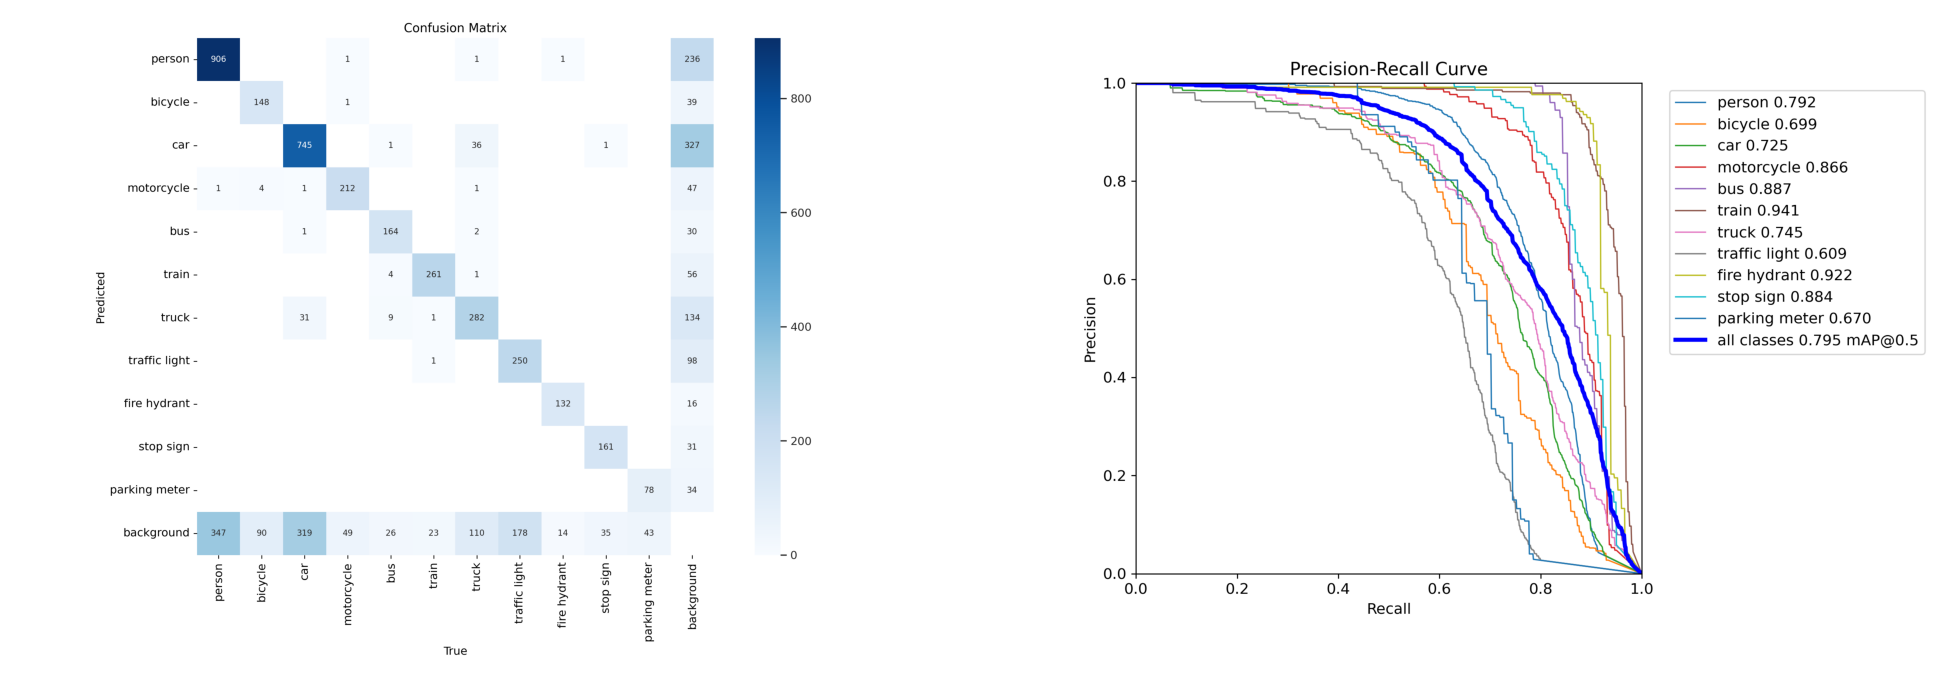

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,15))

img = mpimg.imread(os.path.join(runs_dir, 'confusion_matrix.png'))
ax[0].imshow(img)
ax[0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'PR_curve.png'))
ax[1].imshow(img)
ax[1].axis('off')
plt.show()

---

## Model 5 - Deep Layer Freezing with Focal Loss
- **Objective:**  Assess focal loss's effectiveness in improving detection of smaller and harder-to-detect objects
 - Unreeze last layer only.
 - Use Focal Loss
 - Keep other previous settings

- **Base Model:** yolov8s.pt
- **Dataset:** custom_focal_loss.yaml
- **Training Parameters**
 - Epochs: 50
 - Batch Size: 32
 - Freeze: 22
 - Image Size: Default (640x640)
 - Include background images
 - Loss Function = Focal Loss



### 5.1 Training

In [ ]:
# custom function to freeze layers
def freeze_layer(trainer):
    model = trainer.model
    num_freeze = 22
    print(f"Freezing {num_freeze} layers")
    freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze
    for k, v in model.named_parameters():
      v.requires_grad = True  # train all layers
      if any(x in k for x in freeze):
        v.requires_grad = False
        print(f'freezing {k}, {v.requires_grad}')
      else:
        print(f'not freezing {k}, {v.requires_grad}')

    print(f"{num_freeze} layers are freezed.")

model = YOLO('yolov8s.pt')
# for name, param in model.named_parameters():
#     if int(name.split('.')[2]) < 10:  # Adjust the condition based on layer naming
#       param.requires_grad = False

# results = model.train(data=coco_yaml, epochs=50, freeze=22)

model.add_callback('on_train_start', freeze_layer)
results = model.train(
    data=custom_focal_loss_yaml,
    epochs=50,
    batch=32,
    freeze=22,
    project=project_dir)

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/engr5315/coco-focal-loss.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/engr5315/runs, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/train.cache... 10643 images, 530 backgrounds, 0 corrupt: 100%|██████████| 11173/11173 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/val.cache... 1330 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1397/1397 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Freezing 22 layers
freezing model.0.conv.weight, False
freezing model.0.bn.weight, False
freezing model.0.bn.bias, False
freezing model.1.conv.weight, False
freezing model.1.bn.weight, False
freezing model.1.bn.bias, False
freezing model.2.cv1.conv.weight, False
freezing model.2.cv1.bn.weight, False
freezing model.2.cv1.bn.bias, False
freezing model.2.cv2.conv.weight, False
freezing model.2.cv2.bn.weight, False
freezing model.2.cv2.bn.bias, False
freezing model.2.m.0.cv1.conv.weight, False
freezing model.2.m.0.cv1.bn.weight, False
freezing model.2.m.0.cv1.bn.bias, False
freezing model.2.m.0.cv2.conv.weight, False
free

       1/50      3.47G      1.016      1.718      1.163         55        640: 100%|██████████| 350/350 [01:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.845      0.672      0.768      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.01G      1.009      1.063      1.149         35        640: 100%|██████████| 350/350 [00:58<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.34it/s]

                   all       1397       4672      0.833      0.685      0.769      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.24G      1.018      1.047       1.15         16        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.833      0.689      0.775      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.01G      1.012      1.022      1.152         29        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.847      0.688      0.777      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.01G     0.9964      1.002      1.142         37        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.852      0.688       0.78      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.23G     0.9957     0.9853       1.14         31        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.55it/s]

                   all       1397       4672      0.857      0.689      0.783      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.01G     0.9986     0.9809      1.143         14        640: 100%|██████████| 350/350 [00:58<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.856      0.688      0.781      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.24G     0.9898     0.9636      1.135         47        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.864      0.684      0.778      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.01G      0.987     0.9602      1.135         26        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.852       0.69      0.782      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.01G     0.9815     0.9573      1.134         35        640: 100%|██████████| 350/350 [00:57<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.846      0.703      0.787        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.01G     0.9838     0.9445      1.132         35        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]

                   all       1397       4672       0.85      0.701      0.788      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.01G     0.9861     0.9528      1.134         22        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.864      0.691      0.787      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.24G     0.9792     0.9441      1.129         32        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]

                   all       1397       4672      0.837      0.702      0.784      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.23G      0.976     0.9424      1.129         16        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672       0.85      0.695      0.786      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.99G     0.9694     0.9374      1.129         32        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.858      0.699      0.788      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.99G     0.9695     0.9367      1.129         53        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all       1397       4672       0.84       0.71       0.79      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.25G     0.9711     0.9276      1.127         44        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.859      0.698      0.789      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.13G     0.9732     0.9338      1.129         28        640: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.55it/s]

                   all       1397       4672      0.862      0.697       0.79      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.99G     0.9688     0.9192      1.128         22        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.861      0.695      0.788      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.99G     0.9648     0.9242      1.125         24        640: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]

                   all       1397       4672      0.861        0.7      0.787      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.99G     0.9629      0.923      1.123         28        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672       0.86      0.698      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.99G     0.9626     0.9152      1.123         31        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]

                   all       1397       4672      0.831      0.708      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.22G     0.9622     0.9231      1.123         33        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.863      0.697      0.791      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.23G     0.9602     0.9109      1.124         45        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.872      0.699      0.792      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.1G      0.958     0.9101      1.121         36        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.867        0.7      0.792      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.1G     0.9611     0.9063       1.12         27        640: 100%|██████████| 350/350 [00:58<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.865      0.692       0.79      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.97G     0.9552     0.9045      1.121         24        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.865      0.699      0.791      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.19G     0.9561     0.8971      1.119         48        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]

                   all       1397       4672      0.854      0.707      0.791      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.19G     0.9547     0.9015       1.12         35        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.856      0.708      0.794       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.97G     0.9543     0.8979      1.121         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.861      0.704      0.791       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.93G     0.9506     0.8918      1.119         32        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.859      0.698      0.792      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.97G     0.9519     0.8913      1.118         12        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.55it/s]

                   all       1397       4672      0.857      0.699      0.792       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.97G     0.9552     0.8979      1.119         40        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672       0.84      0.709      0.791      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.97G     0.9538     0.8962      1.116         37        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.855      0.707      0.793      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.06G     0.9462     0.8825      1.115         70        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.852      0.709      0.793      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.99G     0.9469     0.8829      1.116         33        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.861      0.702      0.794      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.13G      0.953     0.8875       1.12         30        640: 100%|██████████| 350/350 [00:58<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.853      0.704      0.793      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.16G     0.9517     0.8818      1.117         41        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all       1397       4672      0.875      0.692      0.795       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.19G     0.9452     0.8787      1.113         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]

                   all       1397       4672      0.849      0.713      0.795       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.36G     0.9477     0.8789      1.116         22        640: 100%|██████████| 350/350 [00:57<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.864      0.703      0.794      0.609


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.24G     0.9799     0.9059      1.121         13        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]

                   all       1397       4672      0.812      0.691      0.763       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.03G     0.9712      0.883      1.116          8        640: 100%|██████████| 350/350 [00:55<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.811      0.683      0.762      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.97G     0.9694     0.8801      1.115         13        640: 100%|██████████| 350/350 [00:55<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.823      0.681      0.764      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.97G      0.966     0.8756      1.112          8        640: 100%|██████████| 350/350 [00:55<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.834      0.682      0.764      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.97G     0.9585      0.862      1.108         12        640: 100%|██████████| 350/350 [00:56<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.833      0.681      0.765      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.97G     0.9609     0.8582      1.109         15        640: 100%|██████████| 350/350 [00:57<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.29it/s]

                   all       1397       4672      0.839      0.681      0.766      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       1.9G     0.9621     0.8634      1.111         15        640: 100%|██████████| 350/350 [00:57<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.827       0.69      0.766      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       1.9G     0.9556     0.8536      1.111         10        640: 100%|██████████| 350/350 [00:55<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.825      0.693       0.77      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       1.9G     0.9591     0.8597      1.109         16        640: 100%|██████████| 350/350 [00:55<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.829      0.687      0.768      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.17G      0.954     0.8542      1.105         12        640: 100%|██████████| 350/350 [00:56<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]

                   all       1397       4672      0.824      0.686      0.767      0.574



50 epochs completed in 0.909 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train5/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train5/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train5/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.93it/s]


                   all       1397       4672      0.851      0.712      0.795       0.61
                person        586       1254      0.864      0.668      0.792      0.579
               bicycle        134        242      0.857      0.529      0.699      0.488
                   car        480       1097      0.781       0.64      0.725      0.518
            motorcycle        144        263      0.883      0.778      0.866      0.637
                   bus        139        204      0.929      0.839      0.887      0.768
                 train        238        286      0.895      0.895      0.941      0.756
                 truck        273        433       0.77      0.644      0.745      0.585
         traffic light        160        428      0.801      0.517      0.609      0.383
          fire hydrant        140        147      0.929      0.897      0.922       0.72
             stop sign        169        197      0.885      0.787      0.884      0.753
         parking mete

### 5.2 Validation

In [ ]:
runs_dir = results.save_dir
best_model_path = os.path.join(runs_dir, 'weights/best.pt')
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from best model
model = YOLO(best_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_05_best'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:20<00:00,  4.39it/s]


                   all       1398       4780      0.838      0.707      0.787      0.607
                person        558       1222      0.871      0.659      0.769       0.54
               bicycle        114        207      0.836      0.642      0.726      0.523
                   car        496       1202      0.773      0.647      0.734      0.508
            motorcycle        161        261      0.895      0.713      0.826      0.616
                   bus        131        214      0.935       0.86       0.92      0.779
                 train        214        297      0.879      0.875      0.929      0.732
                 truck        277        428      0.735      0.657      0.726      0.572
         traffic light        176        465        0.8      0.538      0.629        0.4
          fire hydrant        185        191      0.901      0.812      0.871      0.731
             stop sign        170        187      0.795      0.802       0.86      0.769
         parking mete

In [ ]:
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from last model
model = YOLO(last_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_05_last'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:10<00:00,  8.68it/s]


                   all       1398       4780      0.825      0.676      0.762      0.573
                person        558       1222      0.863      0.631      0.741      0.515
               bicycle        114        207      0.821      0.594        0.7       0.48
                   car        496       1202      0.781      0.609      0.712       0.48
            motorcycle        161        261      0.885      0.686      0.791      0.568
                   bus        131        214      0.931      0.823      0.895      0.738
                 train        214        297      0.829      0.822      0.893      0.694
                 truck        277        428      0.716        0.6      0.692      0.519
         traffic light        176        465        0.8       0.51      0.603      0.377
          fire hydrant        185        191      0.858       0.77      0.839      0.689
             stop sign        170        187      0.796      0.802       0.85      0.748
         parking mete


### 5.3 Results

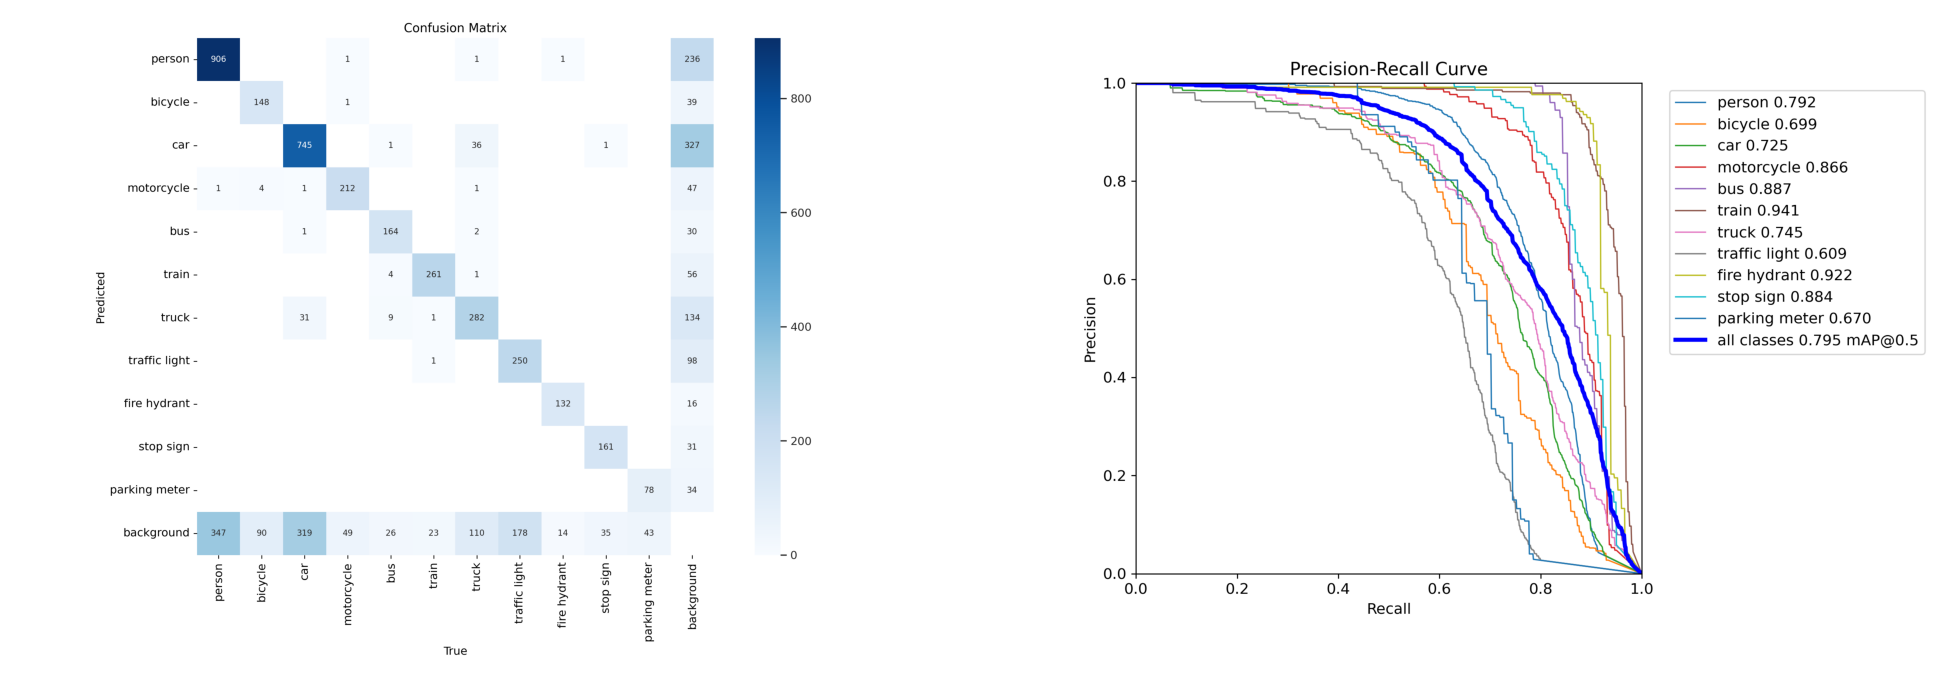

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,15))

img = mpimg.imread(os.path.join(runs_dir, 'confusion_matrix.png'))
ax[0].imshow(img)
ax[0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'PR_curve.png'))
ax[1].imshow(img)
ax[1].axis('off')
plt.show()

---

## Model 6 - Optimizer (SGD)
- **Objective:** Analyze the impact of using SGD as the optimizer on convergence and performance.  
 - Keep previous settings
 - Change optimzer from to SGD

- **Base Model:** yolov8s.pt
- **Dasaset:** coco-focal-loss.yaml
- **Training Parameters**
 - Epochs: 50
 - Batch Size: 32
 - Freeze: 22
 - Image Size: Default (640x640)
 - Include background images
 - Loss Function: Focal Loss
 - Optimizer: SGD

### 6.1 Training

In [ ]:
# custom function to freeze layers
def freeze_layer(trainer):
    model = trainer.model
    num_freeze = 22
    print(f"Freezing {num_freeze} layers")
    freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze
    for k, v in model.named_parameters():
      v.requires_grad = True  # train all layers
      if any(x in k for x in freeze):
        v.requires_grad = False
        print(f'freezing {k}, {v.requires_grad}')
      else:
        print(f'not freezing {k}, {v.requires_grad}')

    print(f"{num_freeze} layers are freezed.")

model = YOLO('yolov8s.pt')
model.add_callback('on_train_start', freeze_layer)
results = model.train(
    data=custom_focal_loss_yaml,
    epochs=50,
    batch=32,
    freeze=22,
    optimizer='SGD',
    project=project_dir)

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/engr5315/coco-focal-loss.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/engr5315/runs, name=train6, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

train: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/train.cache... 10643 images, 530 backgrounds, 0 corrupt: 100%|██████████| 11173/11173 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/val.cache... 1330 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1397/1397 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train6/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Freezing 22 layers
freezing model.0.conv.weight, False
freezing model.0.bn.weight, False
freezing model.0.bn.bias, False
freezing model.1.conv.weight, False
freezing model.1.bn.weight, False
freezing model.1.bn.bias, False
freezing model.2.cv1.conv.weight, False
freezing model.2.cv1.bn.weight, False
freezing model.2.cv1.bn.bias, False
freezing model.2.cv2.conv.weight, False
freezing model.2.cv2.bn.weight, False
freezing model.2.cv2.bn.bias, False
freezing model.2.m.0.cv1.conv.weight, False
freezing model.2.m.0.cv1.bn.weight, False
freezing model.2.m.0.cv1.bn.bias, False
freezing model.2.m.0.cv2.conv.weight, False
freezing model.2.m.0.cv2.bn.weight, False
freezing model.2.m.0.cv2.bn.bias, False
freezing model.3.conv.weight, False
freezing model.3.bn.weight, False
freez

       1/50      3.42G      1.022      1.569       1.17         55        640: 100%|██████████| 350/350 [01:01<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.34it/s]

                   all       1397       4672      0.832      0.672      0.759      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.94G      1.034      1.055      1.154         35        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.821      0.687      0.769       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.04G      1.072       1.09       1.17         16        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.833      0.671      0.764      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.02G       1.08      1.085      1.182         29        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]

                   all       1397       4672      0.853      0.676      0.771       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.05G      1.055      1.057      1.169         37        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.829      0.695      0.777      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.28G       1.05      1.035      1.164         31        640: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672       0.85      0.694      0.779      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.04G      1.047      1.026      1.165         14        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.849      0.691      0.779      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.22G      1.031      1.004      1.154         47        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.838      0.691      0.776      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.98G      1.027     0.9974      1.153         26        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.841      0.699      0.781      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.06G       1.02     0.9915      1.151         35        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.31it/s]

                   all       1397       4672      0.842      0.696      0.781      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.98G       1.02     0.9785      1.148         35        640: 100%|██████████| 350/350 [00:57<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]

                   all       1397       4672      0.844      0.703      0.784      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.05G      1.018     0.9824      1.148         22        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.842      0.696      0.782      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.16G       1.01     0.9732      1.142         32        640: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.826      0.703      0.782      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.39G      1.007      0.972      1.142         16        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]

                   all       1397       4672      0.831      0.707      0.783      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.96G     0.9998     0.9646      1.142         32        640: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.849      0.702      0.785      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.02G     0.9971     0.9635      1.141         53        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.55it/s]

                   all       1397       4672      0.851      0.699      0.787      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.22G     0.9984      0.954      1.138         44        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.851      0.707      0.787      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.1G     0.9998      0.959      1.141         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.855      0.703       0.79      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.04G     0.9946     0.9431       1.14         22        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]

                   all       1397       4672      0.854      0.704      0.787      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.03G     0.9895     0.9477      1.136         24        640: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]

                   all       1397       4672      0.853      0.694      0.783      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.01G     0.9872     0.9451      1.133         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.849      0.701      0.784      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.94G     0.9866     0.9374      1.134         31        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.852      0.699      0.786      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.23G     0.9843     0.9446      1.133         33        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]

                   all       1397       4672      0.852      0.701      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.28G     0.9836     0.9301      1.133         45        640: 100%|██████████| 350/350 [00:57<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.859      0.705      0.791      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.97G     0.9788     0.9294       1.13         36        640: 100%|██████████| 350/350 [00:57<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.865      0.692      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.21G     0.9822     0.9257      1.129         27        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.862      0.691      0.788      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.95G     0.9749     0.9239      1.129         24        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all       1397       4672      0.846      0.708      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.06G     0.9766     0.9153      1.127         48        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.55it/s]

                   all       1397       4672      0.844      0.703      0.791      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.18G     0.9742     0.9184      1.128         35        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.862      0.695      0.793      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.03G     0.9728     0.9166      1.129         28        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.853      0.706      0.791      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.99G     0.9698     0.9101      1.127         32        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.851      0.704      0.792      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.06G     0.9699     0.9074      1.126         12        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.846      0.709      0.792      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.94G     0.9719     0.9126      1.126         40        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.844      0.713      0.791      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.93G     0.9708     0.9127      1.123         37        640: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]

                   all       1397       4672      0.862      0.704      0.794      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.01G     0.9636     0.8983      1.122         70        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.861      0.703      0.794      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.92G     0.9627     0.8991      1.123         33        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672       0.85      0.709      0.794      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.95G     0.9674     0.9001      1.126         30        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.57it/s]

                   all       1397       4672      0.868      0.698      0.794      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.08G     0.9651     0.8953      1.123         41        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672       0.87      0.698      0.795      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.04G     0.9587     0.8906      1.119         28        640: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.864      0.704      0.797      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.21G     0.9624      0.891      1.122         22        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.842       0.72      0.795       0.61


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.14G     0.9928     0.9289      1.128         13        640: 100%|██████████| 350/350 [00:58<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.832       0.68      0.763      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.93G     0.9831     0.8976      1.121          8        640: 100%|██████████| 350/350 [00:56<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]

                   all       1397       4672      0.824       0.68      0.761      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.96G     0.9811      0.896      1.121         13        640: 100%|██████████| 350/350 [00:55<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.34it/s]

                   all       1397       4672      0.818      0.682      0.764       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.93G     0.9785     0.8914      1.119          8        640: 100%|██████████| 350/350 [00:55<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]

                   all       1397       4672      0.822      0.686      0.765      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.93G     0.9687     0.8737      1.113         12        640: 100%|██████████| 350/350 [00:56<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672       0.82      0.686      0.767      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.97G     0.9707     0.8681      1.114         15        640: 100%|██████████| 350/350 [00:55<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.818      0.686      0.766      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.96G     0.9685     0.8705      1.115         15        640: 100%|██████████| 350/350 [00:56<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.826      0.687      0.767      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.91G     0.9636     0.8606      1.116         10        640: 100%|██████████| 350/350 [00:56<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]

                   all       1397       4672       0.82      0.691       0.77      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.91G     0.9662     0.8653      1.113         16        640: 100%|██████████| 350/350 [00:55<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.815      0.695      0.768      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.97G     0.9596     0.8571      1.108         12        640: 100%|██████████| 350/350 [00:56<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.819      0.689      0.767      0.573



50 epochs completed in 0.907 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train6/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train6/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train6/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]


                   all       1397       4672      0.863      0.704      0.797      0.612
                person        586       1254      0.877      0.663      0.796       0.58
               bicycle        134        242      0.868      0.533      0.708      0.495
                   car        480       1097      0.815      0.614      0.725      0.519
            motorcycle        144        263      0.881      0.762      0.862      0.631
                   bus        139        204       0.94      0.833      0.893      0.771
                 train        238        286      0.873      0.888      0.936       0.76
                 truck        273        433      0.793      0.621      0.749      0.589
         traffic light        160        428      0.802       0.51      0.607      0.379
          fire hydrant        140        147      0.943      0.902      0.933      0.724
             stop sign        169        197        0.9      0.777      0.878      0.748
         parking mete

### 6.2 Validation

In [ ]:
runs_dir = results.save_dir
best_model_path = os.path.join(runs_dir, 'weights/best.pt')
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from best model
model = YOLO(best_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_06_best'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:20<00:00,  4.27it/s]


                   all       1398       4780      0.813      0.717      0.786      0.608
                person        558       1222      0.845      0.671      0.765      0.541
               bicycle        114        207      0.772      0.647      0.725      0.529
                   car        496       1202      0.748      0.652      0.731      0.509
            motorcycle        161        261      0.899      0.719      0.827      0.614
                   bus        131        214      0.904       0.85      0.925      0.784
                 train        214        297      0.858      0.877      0.926      0.732
                 truck        277        428      0.714      0.673      0.734      0.576
         traffic light        176        465      0.773      0.563      0.627        0.4
          fire hydrant        185        191      0.896      0.814       0.87      0.731
             stop sign        170        187       0.79      0.829      0.866      0.773
         parking mete

In [ ]:
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from last model
model = YOLO(last_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_06_last'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:10<00:00,  8.50it/s]


                   all       1398       4780      0.816      0.683      0.761      0.573
                person        558       1222      0.858      0.646      0.744      0.513
               bicycle        114        207      0.811      0.601      0.705      0.489
                   car        496       1202      0.754       0.62      0.709      0.478
            motorcycle        161        261      0.882      0.685       0.79      0.563
                   bus        131        214      0.922      0.826      0.897      0.741
                 train        214        297      0.844      0.825        0.9      0.698
                 truck        277        428      0.701      0.619      0.686      0.513
         traffic light        176        465      0.784      0.516      0.594      0.371
          fire hydrant        185        191       0.86      0.796      0.848      0.696
             stop sign        170        187      0.786      0.813      0.844      0.747
         parking mete

### 6.3 Results

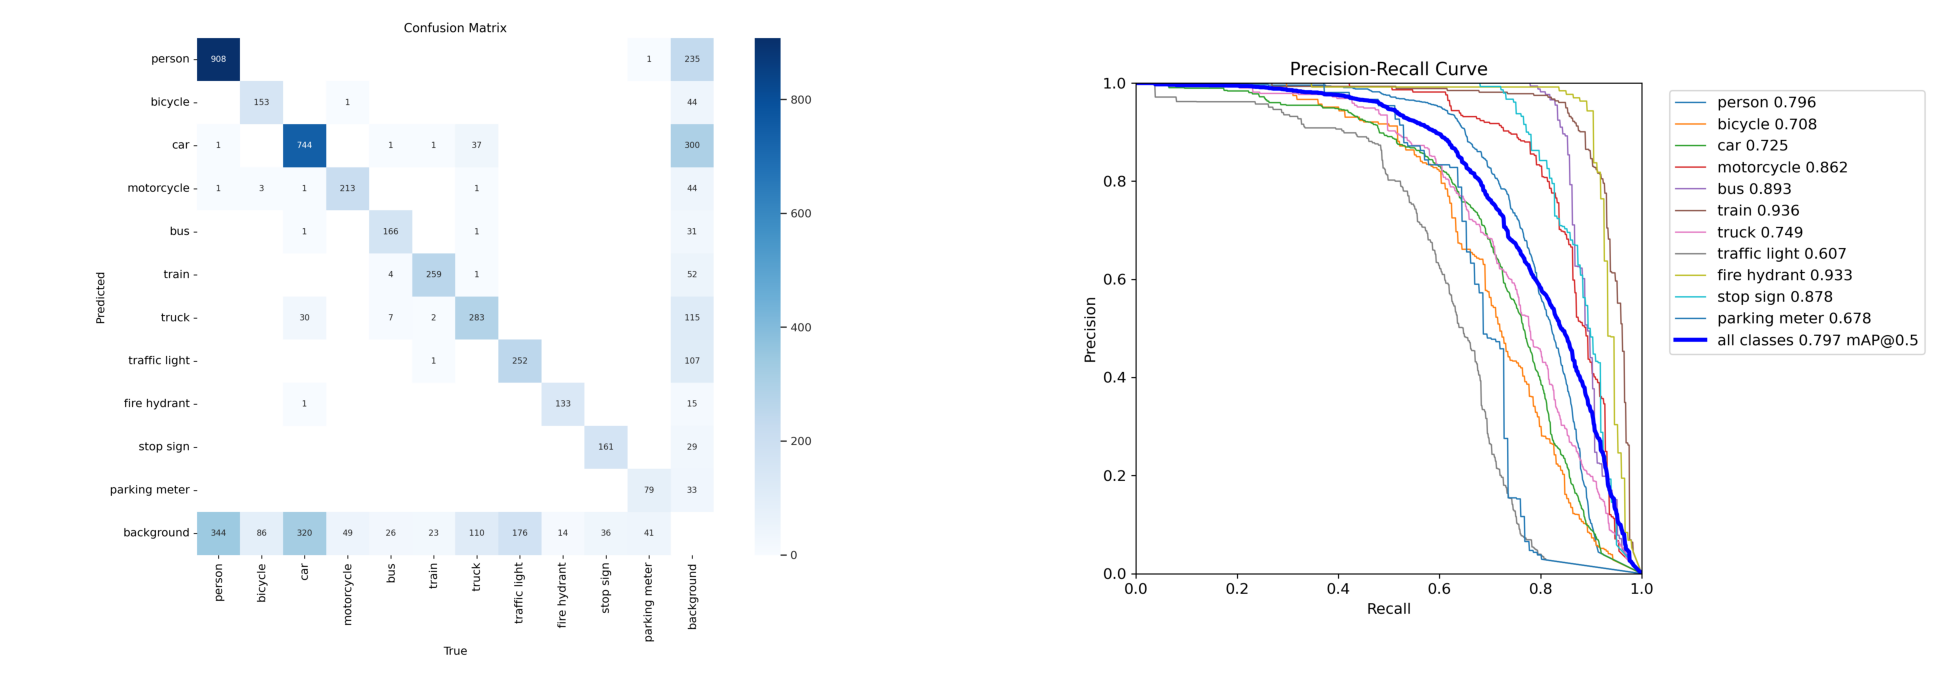

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,15))

img = mpimg.imread(os.path.join(runs_dir, 'confusion_matrix.png'))
ax[0].imshow(img)
ax[0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'PR_curve.png'))
ax[1].imshow(img)
ax[1].axis('off')
plt.show()

---

## Model 7 - Optimizer (RMSProp)
- **Objective:** Evaluate the performance and stability of RMSProp as an alternative optimizer.  
 - Keep previous settings
 - Change optimzer from RMSProp

- **Base Model:** yolov8s.pt
- **Dasaset:** coco-focal-loss.yaml
- **Training Parameters**
 - Epochs: 50
 - Batch Size: 32
 - Freeze: 22
 - Image Size: Default (640x640)
 - Include background images
 - Loss Function: Focal Loss
 - Optimizer: RMSProp

### 7.1 Training

In [ ]:
# custom function to freeze layers
def freeze_layer(trainer):
    model = trainer.model
    num_freeze = 22
    print(f"Freezing {num_freeze} layers")
    freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze
    for k, v in model.named_parameters():
      v.requires_grad = True  # train all layers
      if any(x in k for x in freeze):
        v.requires_grad = False
        print(f'freezing {k}, {v.requires_grad}')
      else:
        print(f'not freezing {k}, {v.requires_grad}')

    print(f"{num_freeze} layers are freezed.")

model = YOLO('yolov8s.pt')
model.add_callback('on_train_start', freeze_layer)
results = model.train(
    data=custom_focal_loss_yaml,
    epochs=50,
    batch=32,
    freeze=22,
    optimizer='RMSProp',
    project=project_dir)

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/engr5315/coco-focal-loss.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/engr5315/runs, name=train7, exist_ok=False, pretrained=True, optimizer=RMSProp, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/train.cache... 10643 images, 530 backgrounds, 0 corrupt: 100%|██████████| 11173/11173 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/val.cache... 1330 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1397/1397 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train7/labels.jpg... 
optimizer: RMSprop(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Freezing 22 layers
freezing model.0.conv.weight, False
freezing model.0.bn.weight, False
freezing model.0.bn.bias, False
freezing model.1.conv.weight, False
freezing model.1.bn.weight, False
freezing model.1.bn.bias, False
freezing model.2.cv1.conv.weight, False
freezing model.2.cv1.bn.weight, False
freezing model.2.cv1.bn.bias, False
freezing model.2.cv2.conv.weight, False
freezing model.2.cv2.bn.weight, False
freezing model.2.cv2.bn.bias, False
freezing model.2.m.0.cv1.conv.weight, False
freezing model.2.m.0.cv1.bn.weight, False
freezing model.2.m.0.cv1.bn.bias, False
freezing model.2.m.0.cv2.conv.weight, False
freezing model.2.m.0.cv2.bn.weight, False
freezing model.2.m.0.cv2.bn.bias, False
freezing model.3.conv.weight, False
freezing model.3.bn.weight, False
f

       1/50      4.05G      1.353       1.75      1.388         55        640: 100%|██████████| 350/350 [01:01<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]

                   all       1397       4672      0.542      0.587      0.564      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.96G      1.274       1.39      1.318         35        640: 100%|██████████| 350/350 [00:59<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]


                   all       1397       4672      0.705      0.565      0.633      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.23G      1.282      1.389      1.312         16        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.27it/s]

                   all       1397       4672      0.589      0.622      0.581      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       2.1G      1.284      1.353       1.32         29        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]

                   all       1397       4672      0.648      0.606      0.629      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         2G      1.255      1.322        1.3         37        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.17it/s]


                   all       1397       4672      0.659      0.565      0.474      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.24G      1.251      1.309      1.293         31        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.552      0.598      0.512      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         2G      1.256      1.292      1.294         14        640: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]

                   all       1397       4672        0.8      0.629      0.715        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.2G      1.242      1.282      1.285         47        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.733      0.638      0.676      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.08G      1.232      1.272      1.279         26        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]

                   all       1397       4672      0.659      0.627      0.581      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.06G      1.232      1.272      1.279         35        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.31it/s]


                   all       1397       4672      0.747      0.632      0.679      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.06G      1.231      1.258      1.275         35        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.726      0.637      0.659      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.96G      1.229      1.269      1.278         22        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.683      0.634      0.606      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.18G      1.215      1.255      1.266         32        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]

                   all       1397       4672      0.527      0.599      0.499       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.45G      1.218      1.258       1.27         16        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.644      0.647      0.635      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.11G      1.209      1.253      1.267         32        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]

                   all       1397       4672      0.716      0.636      0.673      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.02G      1.208      1.248      1.266         53        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.614      0.594      0.626      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.37G      1.205      1.234      1.262         44        640: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.808       0.66      0.738      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.22G      1.208      1.249      1.264         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.732       0.64      0.678      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.93G      1.198      1.228      1.262         22        640: 100%|██████████| 350/350 [00:59<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.802      0.651       0.72      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.96G      1.194      1.234      1.255         24        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.679      0.669       0.62      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.06G      1.187      1.226      1.252         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]

                   all       1397       4672      0.799      0.659      0.732      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.01G      1.183      1.211      1.249         31        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.809       0.65      0.731       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.23G      1.184      1.223      1.249         33        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.793      0.656      0.728      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.27G       1.18        1.2      1.247         45        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.822      0.659      0.747      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.03G      1.172      1.198      1.241         36        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.27it/s]

                   all       1397       4672      0.821      0.639      0.732      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.3G       1.17      1.193      1.235         27        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.807       0.65      0.723      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.95G      1.159      1.189      1.236         24        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]

                   all       1397       4672      0.836      0.664      0.751       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.25G      1.158      1.175      1.234         48        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.834      0.666      0.756      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.23G      1.152      1.177      1.233         35        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.34it/s]

                   all       1397       4672      0.827      0.666      0.753      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.02G      1.149      1.173      1.232         28        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.827      0.678      0.757      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.1G      1.144      1.165      1.227         32        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.827       0.68      0.759      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.06G      1.136      1.157       1.22         12        640: 100%|██████████| 350/350 [00:57<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]

                   all       1397       4672      0.848       0.67      0.761      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.01G      1.138      1.161      1.221         40        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.835      0.677      0.757       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.95G      1.136      1.157      1.217         37        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.31it/s]

                   all       1397       4672      0.826      0.677       0.76       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.07G      1.123       1.14      1.213         70        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]

                   all       1397       4672      0.833      0.677      0.762      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.95G      1.121      1.138      1.211         33        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.835      0.678      0.763      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.08G      1.122      1.138      1.213         30        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]

                   all       1397       4672      0.826      0.678      0.761      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.11G      1.116       1.13      1.209         41        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]

                   all       1397       4672       0.84      0.684      0.768      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.07G      1.106      1.114      1.201         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]

                   all       1397       4672      0.837      0.683      0.767       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.25G      1.105      1.114        1.2         22        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]

                   all       1397       4672      0.845      0.679      0.767      0.582


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.19G      1.125      1.147      1.209         13        640: 100%|██████████| 350/350 [00:58<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.802      0.646      0.732       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.06G      1.115      1.117      1.204          8        640: 100%|██████████| 350/350 [00:55<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672       0.78      0.656      0.729      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.01G      1.106      1.111      1.197         13        640: 100%|██████████| 350/350 [00:55<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.795      0.658      0.738      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.92G      1.097      1.099      1.192          8        640: 100%|██████████| 350/350 [00:55<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.788       0.65      0.733       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.01G      1.083      1.081      1.185         12        640: 100%|██████████| 350/350 [00:56<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.803      0.659      0.741      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.95G       1.08      1.065      1.182         15        640: 100%|██████████| 350/350 [00:55<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672        0.8      0.655      0.739      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.95G      1.069      1.061      1.177         15        640: 100%|██████████| 350/350 [00:56<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]

                   all       1397       4672      0.819      0.655       0.74       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.94G      1.055      1.037      1.173         10        640: 100%|██████████| 350/350 [00:55<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]

                   all       1397       4672      0.816      0.664      0.744      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.96G      1.047      1.028      1.165         16        640: 100%|██████████| 350/350 [00:56<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.802      0.669      0.745      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.93G      1.033       1.01      1.155         12        640: 100%|██████████| 350/350 [00:55<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all       1397       4672      0.799      0.671      0.746      0.555



50 epochs completed in 0.910 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train7/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train7/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train7/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.74it/s]


                   all       1397       4672       0.84      0.685      0.768      0.582
                person        586       1254      0.842      0.669       0.77      0.554
               bicycle        134        242      0.857      0.529      0.686      0.472
                   car        480       1097      0.753      0.622      0.697      0.486
            motorcycle        144        263      0.845      0.768      0.842      0.612
                   bus        139        204      0.911      0.804      0.874      0.745
                 train        238        286      0.866      0.867      0.915      0.722
                 truck        273        433      0.786      0.604      0.721      0.546
         traffic light        160        428      0.818      0.479      0.562      0.354
          fire hydrant        140        147      0.937      0.844      0.907      0.702
             stop sign        169        197      0.858      0.736      0.825      0.702
         parking mete

### 7.2 Validation

In [ ]:
runs_dir = results.save_dir
best_model_path = os.path.join(runs_dir, 'weights/best.pt')
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from best model
model = YOLO(best_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_07_best'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:21<00:00,  4.08it/s]


                   all       1398       4780      0.828      0.669      0.752      0.574
                person        558       1222      0.843      0.645      0.737      0.515
               bicycle        114        207      0.826      0.529       0.68      0.476
                   car        496       1202      0.745      0.613       0.69       0.47
            motorcycle        161        261      0.873       0.72      0.813      0.587
                   bus        131        214      0.925      0.806      0.892      0.745
                 train        214        297      0.883      0.832      0.901      0.697
                 truck        277        428      0.727      0.629      0.694      0.538
         traffic light        176        465      0.767      0.497       0.58      0.365
          fire hydrant        185        191      0.935      0.757      0.841      0.705
             stop sign        170        187      0.801      0.781      0.841      0.751
         parking mete

In [ ]:
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from last model
model = YOLO(last_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_07_last'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:12<00:00,  7.20it/s]


                   all       1398       4780      0.815      0.656      0.734      0.551
                person        558       1222      0.825      0.624      0.718      0.496
               bicycle        114        207      0.769      0.536      0.659      0.451
                   car        496       1202      0.747      0.596      0.677      0.456
            motorcycle        161        261       0.86       0.68      0.777       0.55
                   bus        131        214      0.915      0.813       0.88      0.725
                 train        214        297      0.838      0.818      0.885      0.667
                 truck        277        428       0.72      0.583      0.675      0.497
         traffic light        176        465      0.773      0.483      0.558      0.348
          fire hydrant        185        191      0.865       0.77      0.823      0.672
             stop sign        170        187      0.822      0.791      0.825      0.738
         parking mete

### 7.3 Results

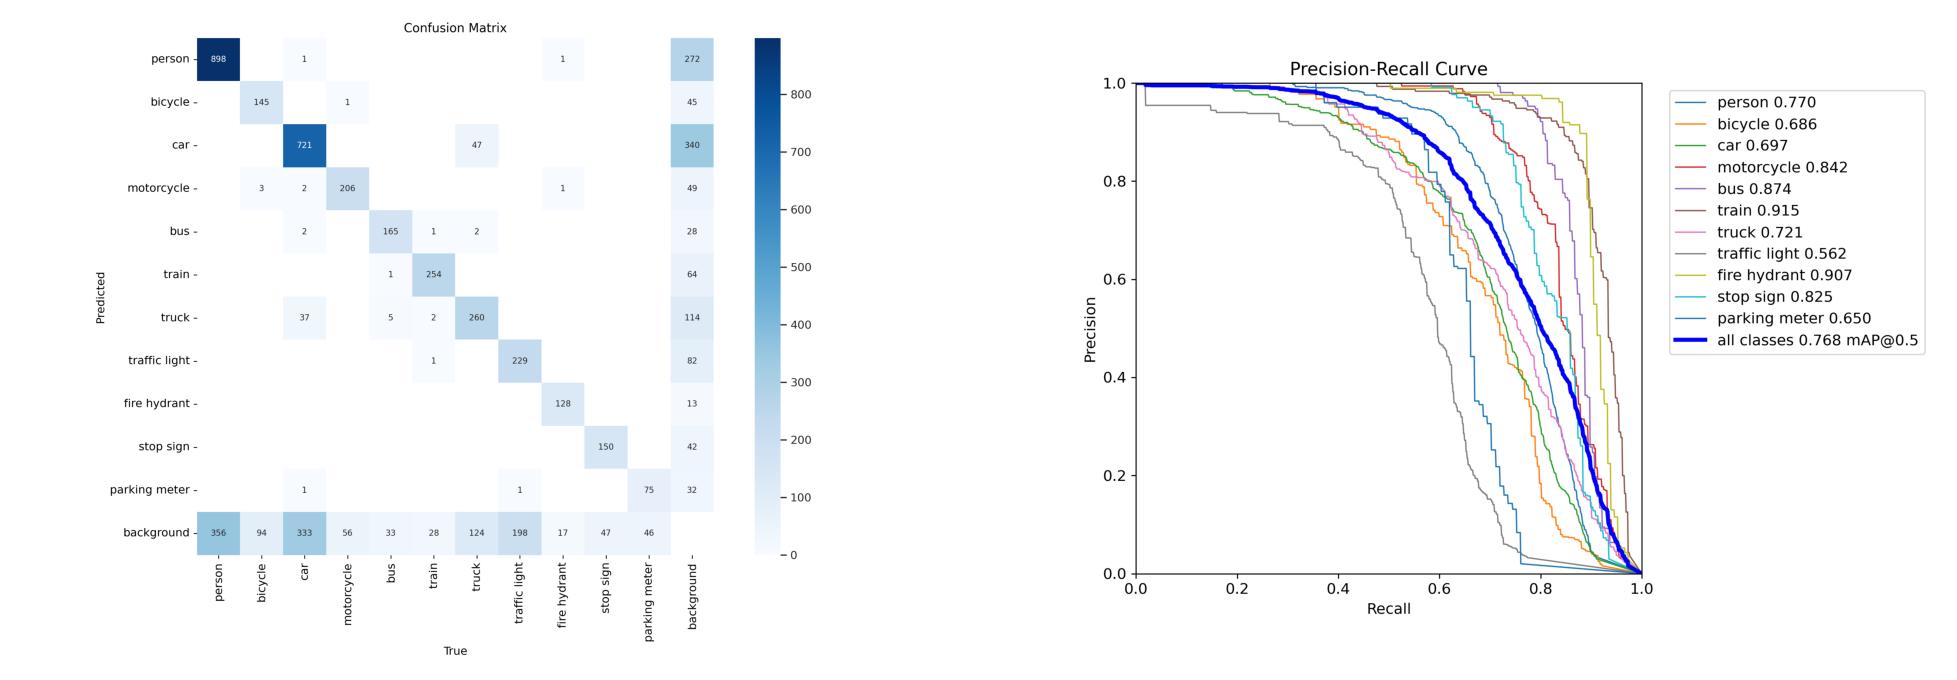

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,15))

img = mpimg.imread(os.path.join(runs_dir, 'confusion_matrix.png'))
ax[0].imshow(img)
ax[0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'PR_curve.png'))
ax[1].imshow(img)
ax[1].axis('off')
plt.show()

---
📶 **Interim Summary**

In [ ]:
pd.DataFrame(test_results)

run_01_best  run_01_last  run_02_best  run_02_last  \
metrics/precision(B)     0.788032     0.811603     0.816686     0.814901   
metrics/recall(B)        0.638386     0.626985     0.678384     0.666831   
metrics/mAP50(B)         0.705383     0.707358     0.759135     0.746511   
metrics/mAP50-95(B)      0.519080     0.522249     0.568289     0.559047   
fitness                  0.537710     0.540760     0.587374     0.577794   

                      run_03_best  run_03_last  run_04_best  run_04_last  \
metrics/precision(B)     0.800040     0.776094     0.838325     0.825455   
metrics/recall(B)        0.633503     0.652223     0.707174     0.676460   
metrics/mAP50(B)         0.707405     0.705881     0.786625     0.761941   
metrics/mAP50-95(B)      0.522197     0.522270     0.606805     0.573027   
fitness                  0.540718     0.540631     0.624787     0.591919   

                      run_05_best  run_05_last  run_06_best  run_06_last  \
metrics/precision(B)     0.838325     0.825455     0.812806     0.815714   
metrics/recall(B)        0.707174     0.676460     0.717295     0.683460   
metrics/mAP50(B)         0.786625     0.761941     0.785602     0.760685   
metrics/mAP50-95(B)      0.606805     0.573027     0.608329     0.572901   
fitness                  0.624787     0.591919     0.626056     0.591679   

                      run_07_best  run_07_last  
metrics/precision(B)     0.828315     0.814640  
metrics/recall(B)        0.669411     0.655739  
metrics/mAP50(B)         0.752449     0.733566  
metrics/mAP50-95(B)      0.574146     0.550530  
fitness                  0.591976     0.568833

In [ ]:
# best model = model 6 - with SGD optimizer

## Model 8 - Reduced Mosaic Augmentation (from Model 6)
- **Objective:** From the best model, determine the effect of reducing mosaic augmentation in the final training stages to enhance real-world application accuracy

- **Base Model:** yolov8s.pt
- **Dataset:** custom_focal_loss_yaml  
- **Training Parameters:**  
  - Epochs: 50  
  - Batch Size: 32  
  - Frozen Layers: 22  
  - Optimizer: SGD  
  - Mosaic Augmentation: Disabled for the last 10 epochs  
  - Image Size: Default (640x640)  


### 8.1 Training

In [ ]:
# without mosaic augmentation applied to last 10 epochs
# custom function to freeze layers
def freeze_layer(trainer):
    model = trainer.model
    num_freeze = 22
    print(f"Freezing {num_freeze} layers")
    freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze
    for k, v in model.named_parameters():
      v.requires_grad = True  # train all layers
      if any(x in k for x in freeze):
        v.requires_grad = False
        print(f'freezing {k}, {v.requires_grad}')
      else:
        print(f'not freezing {k}, {v.requires_grad}')

    print(f"{num_freeze} layers are freezed.")

model = YOLO('yolov8s.pt')
model.add_callback('on_train_start', freeze_layer)
results = model.train(
    data=custom_focal_loss_yaml,
    epochs=50,
    batch=32,
    freeze=22,
    optimizer='SGD',
    close_mosaic=0,
    project=project_dir)

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/engr5315/coco-focal-loss.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/engr5315/runs, name=train8, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=F

train: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/train.cache... 10643 images, 530 backgrounds, 0 corrupt: 100%|██████████| 11173/11173 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/val.cache... 1330 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1397/1397 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train8/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Freezing 22 layers
freezing model.0.conv.weight, False
freezing model.0.bn.weight, False
freezing model.0.bn.bias, False
freezing model.1.conv.weight, False
freezing model.1.bn.weight, False
freezing model.1.bn.bias, False
freezing model.2.cv1.conv.weight, False
freezing model.2.cv1.bn.weight, False
freezing model.2.cv1.bn.bias, False
freezing model.2.cv2.conv.weight, False
freezing model.2.cv2.bn.weight, False
freezing model.2.cv2.bn.bias, False
freezing model.2.m.0.cv1.conv.weight, False
freezing model.2.m.0.cv1.bn.weight, False
freezing model.2.m.0.cv1.bn.bias, False
freezing model.2.m.0.cv2.conv.weight, False
freezing model.2.m.0.cv2.bn.weight, False
freezing model.2.m.0.cv2.bn.bias, False
freezing model.3.conv.weight, False
freezing model.3.bn.weight, False
freez

       1/50      4.25G      1.022      1.569       1.17         55        640: 100%|██████████| 350/350 [01:01<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.832      0.672      0.759      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.01G      1.034      1.055      1.154         35        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.821      0.687      0.769       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.27G      1.072       1.09       1.17         16        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.833      0.671      0.764      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.03G       1.08      1.085      1.182         29        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.853      0.676      0.771       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.05G      1.055      1.057      1.169         37        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

                   all       1397       4672      0.829      0.695      0.777      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.18G       1.05      1.035      1.164         31        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]

                   all       1397       4672       0.85      0.694      0.779      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.05G      1.047      1.026      1.165         14        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]

                   all       1397       4672      0.849      0.691      0.779      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.15G      1.031      1.004      1.154         47        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

                   all       1397       4672      0.838      0.691      0.776      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.98G      1.027     0.9974      1.153         26        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.34it/s]

                   all       1397       4672      0.841      0.699      0.781      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.97G       1.02     0.9915      1.151         35        640: 100%|██████████| 350/350 [00:58<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]

                   all       1397       4672      0.842      0.696      0.781      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       1.9G       1.02     0.9785      1.148         35        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.31it/s]

                   all       1397       4672      0.844      0.703      0.784      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.07G      1.018     0.9824      1.148         22        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]

                   all       1397       4672      0.842      0.696      0.782      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.25G       1.01     0.9732      1.142         32        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.826      0.703      0.782      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.42G      1.007      0.972      1.142         16        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.831      0.707      0.783      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.98G     0.9998     0.9646      1.142         32        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]

                   all       1397       4672      0.849      0.702      0.785      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.99G     0.9971     0.9635      1.141         53        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.851      0.699      0.787      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.38G     0.9984      0.954      1.138         44        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.54it/s]

                   all       1397       4672      0.851      0.707      0.787      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.24G     0.9998      0.959      1.141         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.855      0.703       0.79      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.98G     0.9946     0.9431       1.14         22        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.854      0.704      0.787      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.01G     0.9895     0.9477      1.136         24        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]

                   all       1397       4672      0.853      0.694      0.783      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.98G     0.9872     0.9451      1.133         28        640: 100%|██████████| 350/350 [00:57<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]

                   all       1397       4672      0.849      0.701      0.784      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.93G     0.9866     0.9374      1.134         31        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]

                   all       1397       4672      0.852      0.699      0.786      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.24G     0.9843     0.9446      1.133         33        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.852      0.701      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.28G     0.9836     0.9301      1.133         45        640: 100%|██████████| 350/350 [00:57<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]

                   all       1397       4672      0.859      0.705      0.791      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         2G     0.9788     0.9294       1.13         36        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.34it/s]

                   all       1397       4672      0.865      0.692      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.2G     0.9822     0.9257      1.129         27        640: 100%|██████████| 350/350 [00:57<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.862      0.691      0.788      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.98G     0.9749     0.9239      1.129         24        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]

                   all       1397       4672      0.846      0.708      0.789      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.16G     0.9766     0.9153      1.127         48        640: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.844      0.703      0.791      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.28G     0.9742     0.9184      1.128         35        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]

                   all       1397       4672      0.862      0.695      0.793      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         2G     0.9728     0.9166      1.129         28        640: 100%|██████████| 350/350 [00:58<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.853      0.706      0.791      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.14G     0.9698     0.9101      1.127         32        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]

                   all       1397       4672      0.851      0.704      0.792      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.98G     0.9699     0.9074      1.126         12        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all       1397       4672      0.846      0.709      0.792      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.11G     0.9719     0.9126      1.126         40        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]

                   all       1397       4672      0.844      0.713      0.791      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.05G     0.9708     0.9127      1.123         37        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]

                   all       1397       4672      0.862      0.704      0.794      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.08G     0.9636     0.8983      1.122         70        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]

                   all       1397       4672      0.861      0.703      0.794      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.07G     0.9627     0.8991      1.123         33        640: 100%|██████████| 350/350 [00:57<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672       0.85      0.709      0.794      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.16G     0.9674     0.9001      1.126         30        640: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]

                   all       1397       4672      0.868      0.698      0.794      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.19G     0.9651     0.8953      1.123         41        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672       0.87      0.698      0.795      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.13G     0.9587     0.8906      1.119         28        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]

                   all       1397       4672      0.864      0.704      0.797      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.2G     0.9624      0.891      1.122         22        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.842       0.72      0.795       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.97G     0.9528     0.8866      1.118         16        640: 100%|██████████| 350/350 [00:57<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]

                   all       1397       4672      0.863      0.699      0.795      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.03G     0.9579     0.8877      1.122         39        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]

                   all       1397       4672      0.868      0.705      0.797       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.29G     0.9561     0.8787      1.118         21        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]

                   all       1397       4672      0.852      0.709      0.796      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.26G     0.9507     0.8859      1.116         23        640: 100%|██████████| 350/350 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]

                   all       1397       4672      0.871      0.698      0.796       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.96G       0.95     0.8775      1.119         19        640: 100%|██████████| 350/350 [00:58<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

                   all       1397       4672      0.839      0.717      0.797      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.26G     0.9479     0.8722      1.117         25        640: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.863      0.702      0.795      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         2G     0.9497     0.8732      1.115         14        640: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]

                   all       1397       4672      0.859      0.704      0.794       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.03G     0.9441     0.8664      1.113         36        640: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]

                   all       1397       4672      0.871      0.701      0.794       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.02G     0.9399     0.8621      1.115         54        640: 100%|██████████| 350/350 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]

                   all       1397       4672      0.871        0.7      0.796      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.96G      0.947     0.8717      1.116         66        640: 100%|██████████| 350/350 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]

                   all       1397       4672      0.873      0.701      0.796      0.611



50 epochs completed in 0.912 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train8/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train8/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/Colab Notebooks/engr5315/runs/train8/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  2.87it/s]


                   all       1397       4672      0.863      0.704      0.797      0.612
                person        586       1254      0.877      0.663      0.796       0.58
               bicycle        134        242      0.868      0.533      0.708      0.495
                   car        480       1097      0.815      0.614      0.725      0.519
            motorcycle        144        263      0.881      0.762      0.862      0.631
                   bus        139        204       0.94      0.833      0.893      0.771
                 train        238        286      0.873      0.888      0.936       0.76
                 truck        273        433      0.793      0.621      0.749      0.589
         traffic light        160        428      0.802       0.51      0.607      0.379
          fire hydrant        140        147      0.943      0.902      0.933      0.724
             stop sign        169        197        0.9      0.777      0.878      0.748
         parking mete

### 8.2 Validation

In [ ]:
runs_dir = results.save_dir
best_model_path = os.path.join(runs_dir, 'weights/best.pt')
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from best model
model = YOLO(best_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_08_best'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]


                   all       1398       4780      0.813      0.717      0.786      0.608
                person        558       1222      0.845      0.671      0.765      0.541
               bicycle        114        207      0.772      0.647      0.725      0.529
                   car        496       1202      0.748      0.652      0.731      0.509
            motorcycle        161        261      0.899      0.719      0.827      0.614
                   bus        131        214      0.904       0.85      0.925      0.784
                 train        214        297      0.858      0.877      0.926      0.732
                 truck        277        428      0.714      0.673      0.734      0.576
         traffic light        176        465      0.773      0.563      0.627        0.4
          fire hydrant        185        191      0.896      0.814       0.87      0.731
             stop sign        170        187       0.79      0.829      0.866      0.773
         parking mete

In [ ]:
last_model_path = os.path.join(runs_dir, 'weights/last.pt')

# validate from last model
model = YOLO(last_model_path)
metrics = model.val(data=custom_focal_loss_yaml, split='test', project=project_dir, save_json=True)
test_results['run_08_last'] = metrics.results_dict

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/engr5315/datasets/coco-custom-with-null/labels/test.cache... 1331 images, 67 backgrounds, 0 corrupt: 100%|██████████| 1398/1398 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:10<00:00,  8.79it/s]


                   all       1398       4780      0.828      0.711      0.787      0.608
                person        558       1222      0.853      0.667      0.766      0.543
               bicycle        114        207      0.834      0.618      0.721      0.533
                   car        496       1202      0.769      0.655      0.736       0.51
            motorcycle        161        261        0.9      0.716       0.83      0.617
                   bus        131        214      0.895       0.84      0.915      0.776
                 train        214        297      0.888      0.869       0.93      0.737
                 truck        277        428      0.743       0.67      0.743      0.581
         traffic light        176        465      0.781      0.552      0.626      0.398
          fire hydrant        185        191      0.904      0.822      0.873      0.722
             stop sign        170        187      0.798      0.813      0.869      0.776
         parking mete

### 8.3 Results

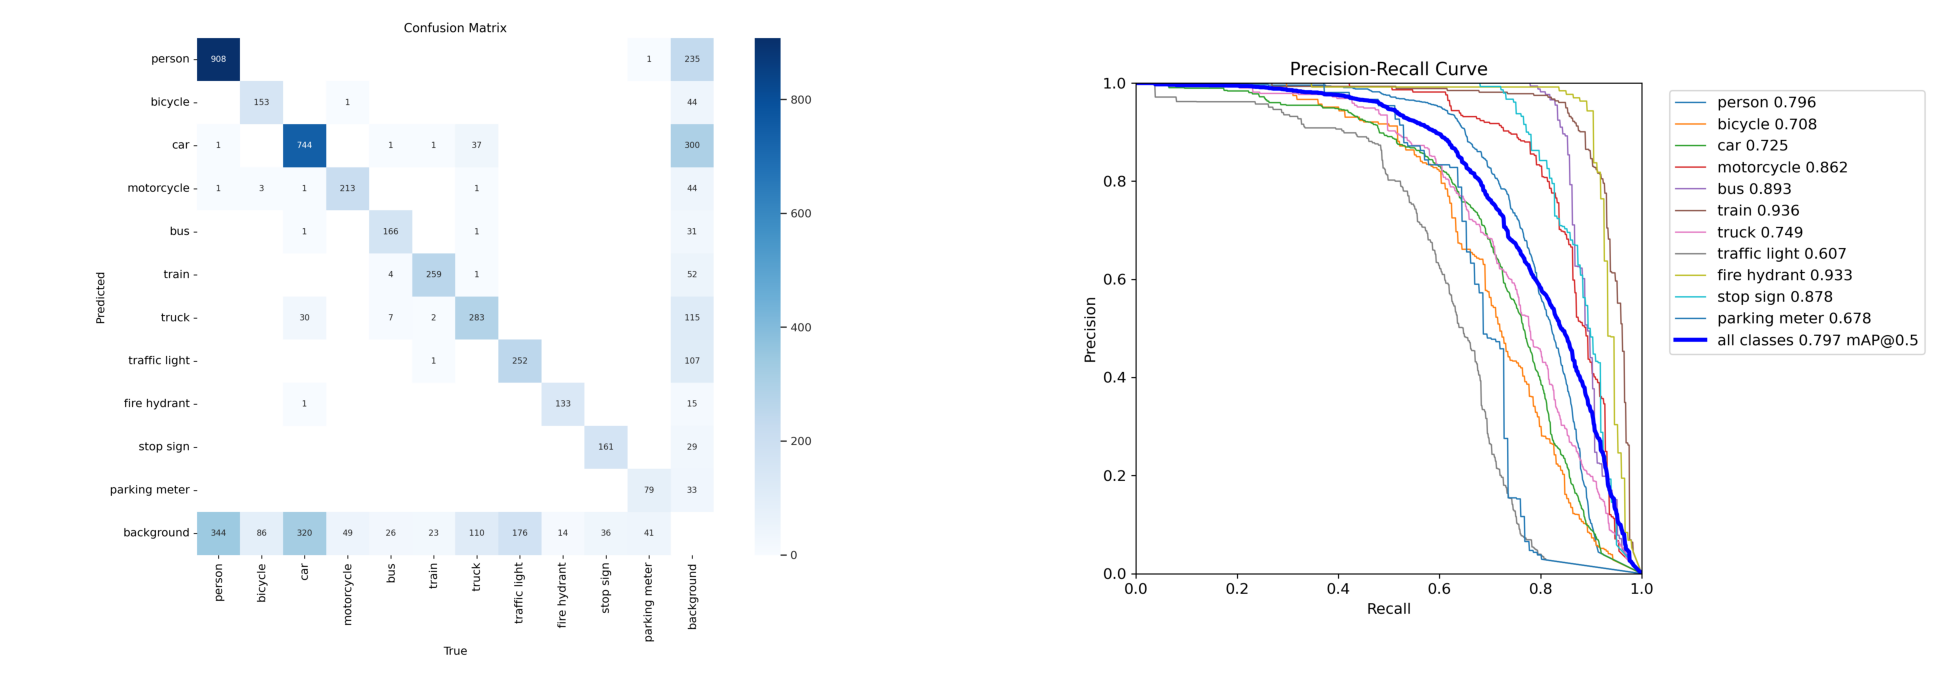

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,15))

img = mpimg.imread(os.path.join(runs_dir, 'confusion_matrix.png'))
ax[0].imshow(img)
ax[0].axis('off')

img = mpimg.imread(os.path.join(runs_dir, 'PR_curve.png'))
ax[1].imshow(img)
ax[1].axis('off')
plt.show()

## 📶 Model Summary

In [ ]:
pd.DataFrame(test_results)

run_01_best  run_01_last  run_02_best  run_02_last  \
metrics/precision(B)     0.788032     0.811603     0.816686     0.814901   
metrics/recall(B)        0.638386     0.626985     0.678384     0.666831   
metrics/mAP50(B)         0.705383     0.707358     0.759135     0.746511   
metrics/mAP50-95(B)      0.519080     0.522249     0.568289     0.559047   
fitness                  0.537710     0.540760     0.587374     0.577794   

                      run_03_best  run_03_last  run_04_best  run_04_last  \
metrics/precision(B)     0.800040     0.776094     0.838325     0.825455   
metrics/recall(B)        0.633503     0.652223     0.707174     0.676460   
metrics/mAP50(B)         0.707405     0.705881     0.786625     0.761941   
metrics/mAP50-95(B)      0.522197     0.522270     0.606805     0.573027   
fitness                  0.540718     0.540631     0.624787     0.591919   

                      run_05_best  run_05_last  run_06_best  run_06_last  \
metrics/precision(B)     0.838325     0.825455     0.812806     0.815714   
metrics/recall(B)        0.707174     0.676460     0.717295     0.683460   
metrics/mAP50(B)         0.786625     0.761941     0.785602     0.760685   
metrics/mAP50-95(B)      0.606805     0.573027     0.608329     0.572901   
fitness                  0.624787     0.591919     0.626056     0.591679   

                      run_07_best  run_07_last  run_08_best  run_08_last  
metrics/precision(B)     0.828315     0.814640     0.812806     0.827693  
metrics/recall(B)        0.669411     0.655739     0.717295     0.710578  
metrics/mAP50(B)         0.752449     0.733566     0.785602     0.786869  
metrics/mAP50-95(B)      0.574146     0.550530     0.608329     0.607979  
fitness                  0.591976     0.568833     0.626056     0.625868

## Model 6 vs. Model 8 - Convergence Analysis
- comparison of convergence behavior between Model 6 and Model 8
- loss convergence plot comparison

**Model 6 (SGD Optimizer)**

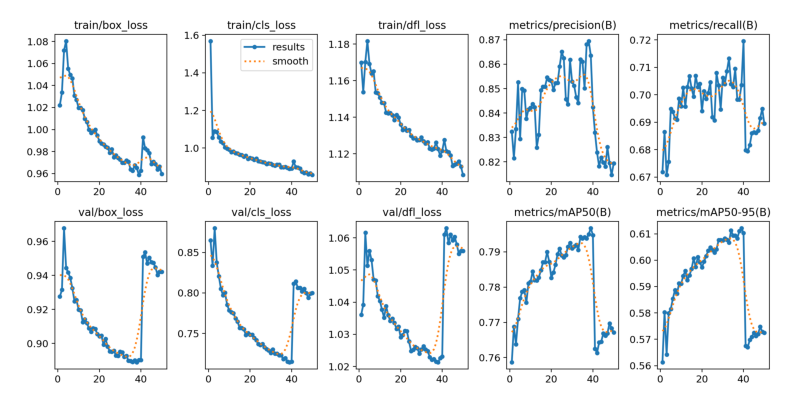

In [ ]:
# compare model 6 vs model 8
runs_dir = os.path.join(project_dir, 'train6')
fig,ax = plt.subplots(figsize=(12,5))

img = mpimg.imread(os.path.join(runs_dir, 'results.png'))
plt.imshow(img)
plt.axis('off')
plt.show()

**Model 8 (SGD Optimizer + Reduced Mosaic)**

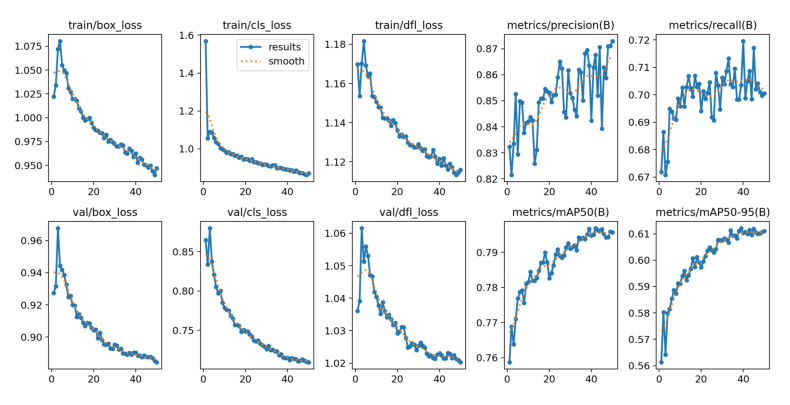

In [ ]:
runs_dir = os.path.join(project_dir, 'train8')
fig,ax = plt.subplots(figsize=(12,5))

img = mpimg.imread(os.path.join(runs_dir, 'results.png'))
plt.imshow(img)
plt.axis('off')
plt.show()

**Observations:**
1. Model 6 (SGD Optimizer):
   - Faster initial convergence, but plateaued early.
   - Training exhibited oscillations during later epochs, potentially due to over-augmentation.  

2. Model 8 (SGD Optimizer + Reduced Mosaic):
   - Similar convergence for initial epochs and continues to improve steadily
   - Reducing mosaic augmentation in the final epochs resulted in smoother convergence and a more consistent validation loss trend

## 📊 Model Benchmark

In [ ]:
runs_dir = os.path.join(project_dir, 'train8')
best_model_path = os.path.join(runs_dir + '/weights', 'best.pt')
best_model = YOLO(best_model_path)

benchmark_results = benchmark(model=best_model, data=custom_focal_loss_yaml, imgsz=640, half=False, device=0)
benchmark_results